# Palm 2 - Modeling - Linear Regression 

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as stats
import seaborn as sns
import math as math
import plotly.graph_objects as go

import time
import random
import seaborn as sns


import numpy as np
from os import path
from PIL import Image

from datetime import datetime
from dateutil import relativedelta
import datetime

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import silhouette_score
from sklearn.datasets import load_iris, load_wine
from sklearn.cluster import DBSCAN

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from io import StringIO

pd.set_option('display.max_rows', 3000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

In [54]:
# My Custom color and font scheme - to be used across all graphs 
my_title_col = 'darkslategray'
my_label_col = 'darkslategray'
my_graph_col = 'darkcyan'
my_title_font = 24
my_label_font = 20
my_ticks_font = 18
sns.color_palette("YlOrBr");

#### Define Functions 

In [55]:
# Functions 

def age_in_months(birth_date):
    difference = relativedelta.relativedelta(datetime.datetime.today(), birth_date)
    months = difference.years * 12 + difference.months
    return months

def age_in_years(birth_date):
    difference = relativedelta.relativedelta(datetime.datetime.today(), birth_date)
    years = difference.years
    return years

def age_from_to(from_date, to_date):
    difference = relativedelta.relativedelta(to_date, from_date)
    months = difference.years * 12 + difference.months
    return months




##### Build Scores function

In [56]:
# Function to catupre evalting metrics from different models
scores_df = pd.DataFrame
scores_df = pd.DataFrame(columns=['Model Type','Dataset','Metric','Score'],index=None)
scores_df.Score.astype(float)

def scores(scores_df,model,dataset,metric,score):
    scores_df = scores_df.append({'Model Type':model,
                'Dataset': dataset,
                'Metric': metric,
                'Score':score},
                ignore_index=True)
    return scores_df

In [57]:
# Code modified from code written by Matthew Garton.

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

## Modeling 

### Approach
- Monthly consolidated rain and crop data for entire estate will be used.
- Data from 1-Apr-2011 to 31-Dec-2019 will be used to train and validate
- Data from 1-Jan-2020 to 31-May-2020

### Review of target variable

In [58]:
#load final fused dataset
df = pd.read_csv("../data/final_fused.csv")
df['date'] = df['date'].apply(lambda x: str(x))
df['date'] = pd.to_datetime(df['date'],yearfirst=True,format="%Y/%m/%d")
df = df.sort_values('date')

dfi = df.copy()
dfi = dfi.set_index('date', drop=True) # set date as index
dfi = dfi[['rain','crop']].resample('M').sum() # resampling for monthly totals
dfi['rain'] = dfi['rain']/195 # removing rain multiplication by no of block (undoing the effect of melt)
dfi = dfi[dfi.index < '2020-01-01'] # train & val dataset

In [59]:
dfi.head()

rain        crop
date                              
2011-04-30  243.377949  7994.20059
2011-05-31   93.778205  8614.03416
2011-06-30   67.302564  7714.13505
2011-07-31  119.758974  8511.76212
2011-08-31    5.344615  7345.95696

In [60]:
dfi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105 entries, 2011-04-30 to 2019-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rain    105 non-null    float64
 1   crop    105 non-null    float64
dtypes: float64(2)
memory usage: 2.5 KB


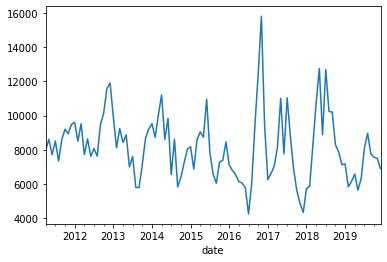

In [61]:
dfi['crop'].plot();

**Observation: Visually crop data has high variance however mean seams to remain in the same ballpark.**

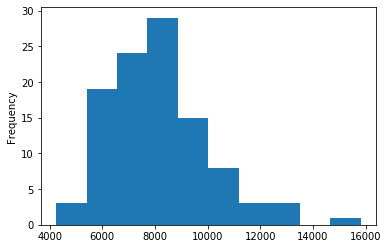

In [62]:
dfi['crop'].plot(kind='hist');

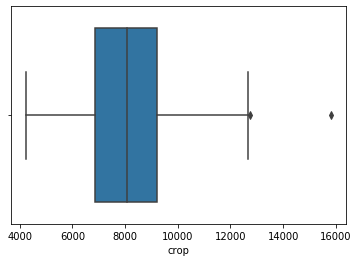

In [63]:
sns.boxplot(dfi['crop']);

In [64]:
dfi[dfi['crop']>13000]

rain         crop
date                               
2016-11-30  593.846154  15805.64415

**Observation: Crop has one outlier at approx. 15000 tons per month.**

### Review Predictor - rain data

In [65]:
dfi.describe()

rain          crop
count  105.000000    105.000000
mean   210.981370   8156.284809
std    124.378317   1919.317589
min      0.000000   4249.610610
25%    119.758974   6863.549750
50%    202.897436   8071.899680
75%    282.571795   9202.491790
max    593.846154  15805.644150

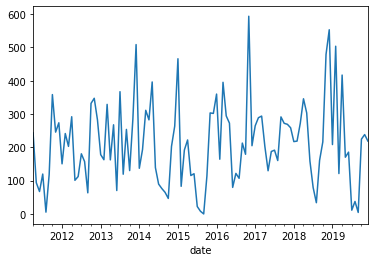

In [66]:
dfi['rain'].plot();

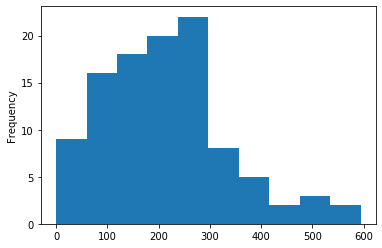

In [67]:
dfi['rain'].plot(kind='hist');

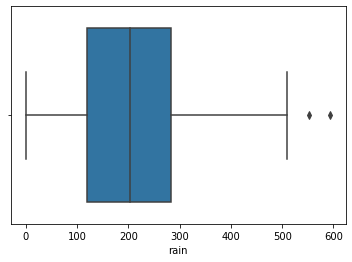

In [68]:
sns.boxplot(dfi['rain']);

In [69]:
dfi[dfi['rain']>500]

rain         crop
date                               
2013-12-31  508.728205   9213.40346
2016-11-30  593.846154  15805.64415
2018-12-31  553.266667   7123.28892
2019-02-28  503.779487   5835.13835

**Observation: There are two outliers beyond 500mm of rain per month.**

### Linear Regression - Phase 1
In phase 1, final_fused.csv is used which contains monthly rain and crop data at estate level

#### Base Model

Scores are computed by predicting all values to be mean of the labelled target feature.

In [70]:
# compute mean of the traget variable 'crop'.
dfi = df.copy()
dfi = dfi.set_index('date', drop=True) # set date as index
dfi = dfi[['rain','crop']].resample('M').sum() # resampling for monthly totals
dfi = dfi[dfi.index < '2020-01-01'] # train & val dataset

dfi['y_preds'] =  dfi['crop'] 
crop_mean = dfi['crop'].mean()
dfi['y_preds'] = dfi['y_preds'].apply(lambda x: crop_mean)

y_val = dfi['crop']
y_preds = dfi['y_preds']

print(f'Mean : {crop_mean}')
print(f'RMSE of Base Model:{math.sqrt(metrics.mean_squared_error(y_val,y_preds))}')
scores_df = scores(scores_df,'Linear Regression Base Model','train_val','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_val,y_preds)),2)}')


Mean : 8156.28480933333
RMSE of Base Model:1910.1561165830115


#### Scenerio - 1

Only use 'rain' data for each month as predictor for that months crop

In [206]:
# Train & Val : 1-apr-2011 to 31-Dec-2019
# Test : 1-Jan-2020 to 31-May-2020


dfi = df.copy()
dfi = dfi.set_index('date', drop=True) # set date as index

dfi = dfi[['rain','crop']].resample('M').sum() # resampling for monthly totals
dfi['rain'] = dfi['rain']/195 # removing rain multiplication by no of block (undoing the effect of melt)

dfi_m_train = dfi[dfi.index < '2020-01-01'].copy() # train & val dataset
dfi_m_test = dfi[dfi.index > '2019-12-31'].copy() # test data
dfi_m_test.drop(dfi_m_test[dfi_m_test.index > '2020-05-31'].index,inplace=True) # keeping data only until 31-may-2020

dfi_m_test.drop('crop',axis=1,inplace=True) # dropping target variable from test dataset

# Removing date as index for modeling
dfi_m_train.reset_index(drop=True,inplace=True)
dfi_m_test.reset_index(drop=True,inplace=True)

# assign predictors and target variables
X = dfi_m_train[['rain']]
y = dfi_m_train['crop']

# split train data into train and validation datasets
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.15,random_state=42)

# change datasets to same scale
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train) 
X_val_scaled = ss.transform(X_val) 
test_scaled = ss.transform(dfi_m_test) # dataset for final test.

# instatiate Linear regression model 
lr1 = LinearRegression()

# fit the model with train dataset
lr1.fit(X_train_scaled, y_train)

# predict on val dataset
y_preds = lr1.predict(X_val_scaled)

#storing score 
scores_df = scores(scores_df,'Linear Regression lr1_S1','train','R2',f'{round(lr1.score(X_train_scaled,y_train),4)}')
scores_df = scores(scores_df,'Linear Regression lr1_S1','Val','R2',f'{round(lr1.score(X_val_scaled,y_val),4)}')
scores_df = scores(scores_df,'Linear Regression lr1_S1','Val','Adj R2',f'{round((1-(1-r2_score(y_val, y_preds))*((len(X_val_scaled)-1)/(len(X_val_scaled)-len(X_val_scaled[0])-1))),4)}')
scores_df = scores(scores_df,'Linear Regression lr1_S1','train','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_train, lr1.predict(X_train_scaled))),2)}')
scores_df = scores(scores_df,'Linear Regression lr1_S1','Val','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_val, lr1.predict(X_val_scaled))),2)}')
scores_df = scores(scores_df,'Linear Regression lr1_S1','train','CVal_3',f'{round(cross_val_score(lr1, X_train_scaled, y_train, cv=3).mean(),4)}')
scores_df.tail()

Model Type Dataset  Metric    Score
72  Linear Regression lr1_S1     Val      R2  -0.2193
73  Linear Regression lr1_S1     Val  Adj R2  -0.3064
74  Linear Regression lr1_S1   train    RMSE  1952.91
75  Linear Regression lr1_S1     Val    RMSE  1510.32
76  Linear Regression lr1_S1   train  CVal_3  -0.1144

#### Scenerio - 1 Evaluation

In [207]:
# residual of LR model on validation dataset
resd = y_val - y_preds
len(resd)

16

In [208]:
resd.mean()

-537.669647058257

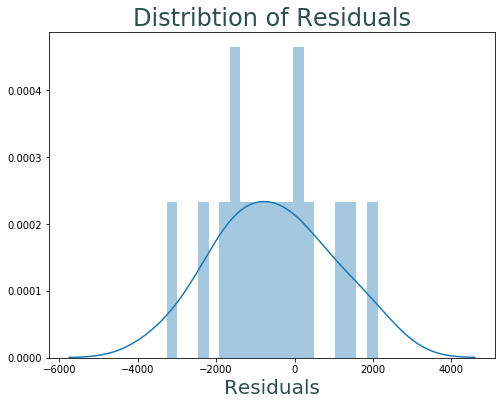

In [209]:
# Plot residuals
xf=resd
#yf=graph['crop']
#cf=graph['']
xlabel='Residuals'
ylabel='crop'
title = 'Distribtion of Residuals'
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.distplot(resd,bins=20);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
#ax.set_xticklabels(fontsize=my_ticks_font);
#ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

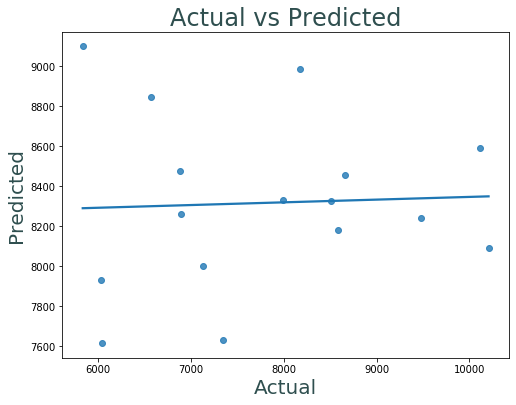

In [210]:
# Plot y_val and y_preds
xf=y_val
yf=y_preds
#cf=graph['']
xlabel='Actual'
ylabel='Predicted'
title = 'Actual vs Predicted'
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.regplot(xf,yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

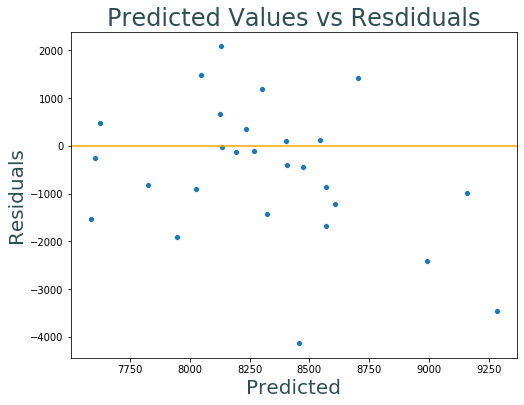

In [76]:
# Plot Predicted vs Residuals
xf=y_preds
yf=resd
#cf=graph['']
xlabel='Predicted'
ylabel='Residuals'
title = 'Predicted Values vs Resdiduals'
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.scatterplot(xf,yf,ci=None);
plt.axhline(0, color='orange');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

#### Scenerio - 1 Conclusion

#### Scenerio - 2

- Use lag of rain data with 12 months and 24 months by adding and shifting rain_12 and rain_24 features
- remove original 'rain' feature since we will not have forecasted rain data in production

In [77]:
#For modeling from train and test datasets
dfi = df.copy()
dfi = dfi.set_index('date', drop=True) # set date as index
dfi = dfi[['rain','crop']].resample('M').sum() # resampling for monthly totals
dfi['rain'] = dfi['rain']/195 # removing rain multiplication by no of block (undoing the effect of melt)

dfi['rain_12'] = dfi['rain'].shift(12) # creating new feature with shift by 12 months
dfi['rain_24'] = dfi['rain'].shift(24) # creating new feature with shift by 12 months

dfi.drop('rain',axis=1,inplace=True) # keeping only rain_12, rain_24 in train dataset as well.

dfi.dropna(inplace=True) # drop first 24 rows with null rain_24 column

# Train & Val : 1-apr-2011 to 31-Dec-2019
# Test : 1-Jan-2020 to 31-May-2020
dfi_m_train = dfi[dfi.index < '2020-01-01'].copy()# train & val dataset from 1-Apr-2011 to 31-Dec-2019

dfi_m_test = dfi[dfi.index > '2019-12-31'].copy() # test dataset from 1-Jan-2020
dfi_m_test.drop(dfi_m_test[dfi_m_test.index > '2020-05-31'].index,inplace=True) # drop rows beyond 31st May 2020
dfi_m_test.drop('crop',axis=1,inplace=True) # drop target variable from test dataset

#remove date index from datasets for modeling 
dfi_m_train.reset_index(drop=True,inplace=True)
dfi_m_test.reset_index(drop=True,inplace=True)

# assign predictors and target variables
X = dfi_m_train[['rain_12','rain_24']]
y = dfi_m_train['crop']


# split train data into train and validation datasets
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.25,random_state=42)

# scaling predictors in train-val and test datasets
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train) 
X_val_scaled = ss.transform(X_val) 
test_scaled = ss.transform(dfi_m_test) # dataset for final test.

# instatiate Linear regression model 
lr2 = LinearRegression()
# fit the model on train dataset
lr2.fit(X_train_scaled, y_train)
# predict on val dataset
y_preds = lr2.predict(X_val_scaled)

#storing scores
scores_df = scores(scores_df,'Linear Regression lr2_S2','Train','R2',f'{round(lr2.score(X_train_scaled,y_train),4)}')
scores_df = scores(scores_df,'Linear Regression lr2_S2','Val','R2',f'{round(lr2.score(X_val_scaled,y_val),4)}')
scores_df = scores(scores_df,'Linear Regression lr2_S2','Val','Adj R2',f'{round((1-(1-r2_score(y_val, y_preds))*((len(X_val_scaled)-1)/(len(X_val_scaled)-len(X_val_scaled[0])-1))),4)}')
scores_df = scores(scores_df,'Linear Regression lr2_S2','train','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_train, lr2.predict(X_train_scaled))),2)}')
scores_df = scores(scores_df,'Linear Regression lr2_S2','Val','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_val, lr2.predict(X_val_scaled))),2)}')
scores_df = scores(scores_df,'Linear Regression lr2_S2','train','CVal_10',f'{round(cross_val_score(lr2, X_train_scaled, y_train, cv=3).mean(),4)}')
scores_df.tail(6)

Model Type Dataset   Metric    Score
7   Linear Regression lr2_S2   Train       R2   0.0389
8   Linear Regression lr2_S2     Val       R2  -0.1747
9   Linear Regression lr2_S2     Val   Adj R2  -0.3052
10  Linear Regression lr2_S2   train     RMSE  1986.81
11  Linear Regression lr2_S2     Val     RMSE  2161.78
12  Linear Regression lr2_S2   train  CVal_10  -0.0578

#### Scenerio - 2 Evaluation

In [78]:
# residual of LR model on validation dataset
resd = y_val - y_preds
len(resd)

21

In [79]:
resd.mean()

-346.8237001494866

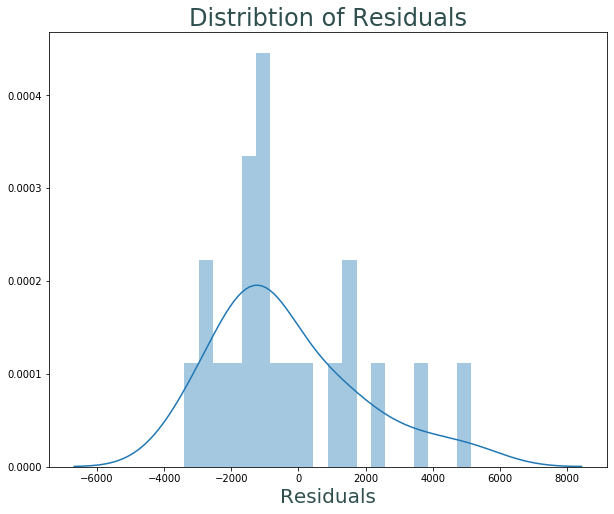

In [80]:
# Plot residuals
xf=resd
#yf=graph['crop']
#cf=graph['']
xlabel='Residuals'
ylabel='crop'
title = 'Distribtion of Residuals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.distplot(resd,bins=20);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
#ax.set_xticklabels(fontsize=my_ticks_font);
#ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

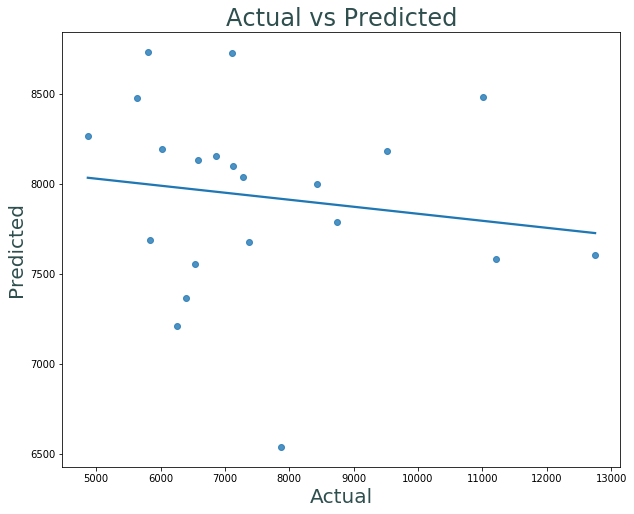

In [81]:
# Plot y_val and y_preds
xf=y_val
yf=y_preds
#cf=graph['']
xlabel='Actual'
ylabel='Predicted'
title = 'Actual vs Predicted'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.regplot(xf,yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

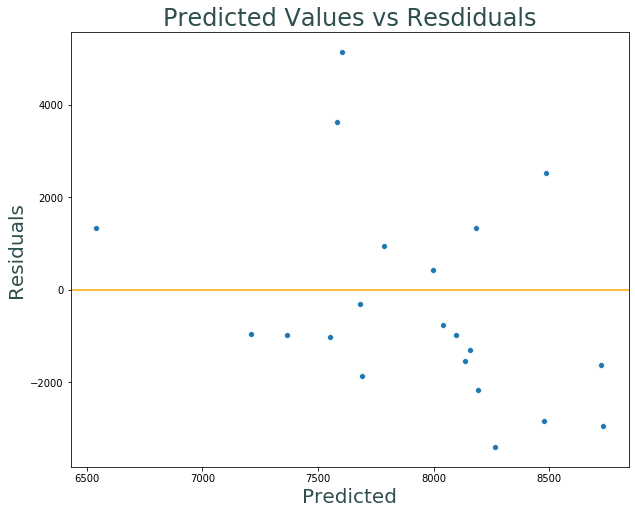

In [82]:
# Plot Predicted vs Residuals
xf=y_preds
yf=resd
#cf=graph['']
xlabel='Predicted'
ylabel='Residuals'
title = 'Predicted Values vs Resdiduals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(xf,yf,ci=None);
plt.axhline(0, color='orange');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

#### Scenerio - 2 Conclusion

#### Scenerio - 3

- use lag of rain data with 12 months and 24 months by adding and shifting rain_12 and rain_24 features
- remove original 'rain' feature since we will not have forecasted rain data in production
- add 'month' in addition to rain_12 and rain_24

In [83]:
#For modeling from train and test datasets
dfi = df.copy()
dfi = dfi.set_index('date', drop=True) # set date as index
dfi = dfi[['rain','crop']].resample('M').sum() # resampling for monthly totals
dfi['rain'] = dfi['rain']/195 # removing rain multiplication by no of block (undoing the effect of melt)

dfi['month'] = dfi.index.month # adding new feature month

dfi['rain_12'] = dfi['rain'].shift(12) # creating new feature with shift by 12 months
dfi['rain_24'] = dfi['rain'].shift(24) # creating new feature with shift by 12 months

dfi.drop('rain',axis=1,inplace=True) # keeping only rain_12, rain_24 in train dataset as well.

dfi.dropna(inplace=True) # drop first 24 rows with null rain_24 column

# Train & Val : 1-apr-2011 to 31-Dec-2019
# Test : 1-Jan-2020 to 31-May-2020
dfi_m_train = dfi[dfi.index < '2020-01-01'].copy()# train & val dataset from 1-Apr-2011 to 31-Dec-2019

dfi_m_test = dfi[dfi.index > '2019-12-31'].copy() # test dataset from 1-Jan-2020
dfi_m_test.drop(dfi_m_test[dfi_m_test.index > '2020-05-31'].index,inplace=True) # drop rows beyond 31st May 2020
dfi_m_test.drop('crop',axis=1,inplace=True) # drop target variable from test dataset

#remove date index from datasets for modeling 
dfi_m_train.reset_index(drop=True,inplace=True)
dfi_m_test.reset_index(drop=True,inplace=True)

# assign predictors and target variables
X = dfi_m_train[['month','rain_12','rain_24']]
y = dfi_m_train['crop']


# split train data into train and validation datasets
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.25,random_state=42)

# scaling predictors in train-val and test datasets
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train) 
X_val_scaled = ss.transform(X_val) 
test_scaled = ss.transform(dfi_m_test) # dataset for final test.

# instatiate Linear regression model 
lr3 = LinearRegression()
# fit the model on train dataset
lr3.fit(X_train_scaled, y_train)
# predict on val dataset
y_preds = lr3.predict(X_val_scaled)

#storing score 
scores_df = scores(scores_df,'Linear Regression lr3_S3','Train','R2',f'{round(lr3.score(X_train_scaled,y_train),4)}')
scores_df = scores(scores_df,'Linear Regression lr3_S3','Val','R2',f'{round(lr3.score(X_val_scaled,y_val),4)}')
scores_df = scores(scores_df,'Linear Regression lr3_S3','Val','Adj R2',f'{round((1-(1-r2_score(y_val, y_preds))*((len(X_val_scaled)-1)/(len(X_val_scaled)-len(X_val_scaled[0])-1))),4)}')
scores_df = scores(scores_df,'Linear Regression lr3_S3','Train','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_train, lr3.predict(X_train_scaled))),2)}')
scores_df = scores(scores_df,'Linear Regression lr3_S3','Val','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_val, lr3.predict(X_val_scaled))),2)}')
scores_df = scores(scores_df,'Linear Regression lr3_S3','Val','CVal_10',f'{round(-cross_val_score(lr3, X_val_scaled, y_val, cv=10).mean(),4)}')
scores_df.tail(6)



Model Type Dataset   Metric      Score
13  Linear Regression lr3_S3   Train       R2     0.0606
14  Linear Regression lr3_S3     Val       R2    -0.2543
15  Linear Regression lr3_S3     Val   Adj R2    -0.4757
16  Linear Regression lr3_S3   Train     RMSE     1964.2
17  Linear Regression lr3_S3     Val     RMSE    2233.86
18  Linear Regression lr3_S3     Val  CVal_10  1551.9196

#### Scenerio - 3 Evaluation

In [84]:
# residual of LR model on validation dataset
resd = y_val - y_preds
len(resd)

21

In [85]:
resd.mean()

-248.63503653615507

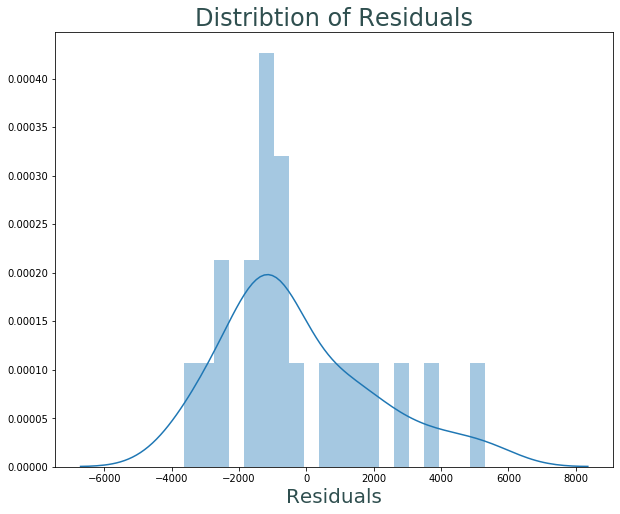

In [86]:
# Plot residuals
xf=resd
#yf=graph['crop']
#cf=graph['']
xlabel='Residuals'
ylabel='crop'
title = 'Distribtion of Residuals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.distplot(resd,bins=20);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
#ax.set_xticklabels(fontsize=my_ticks_font);
#ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

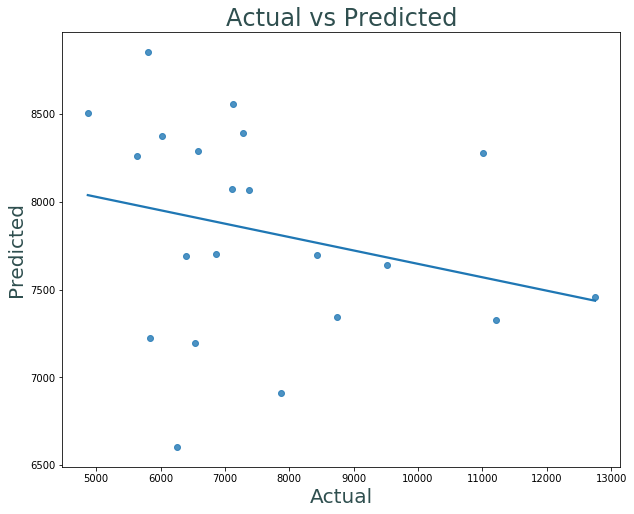

In [87]:
# Plot y_val and y_preds
xf=y_val
yf=y_preds
#cf=graph['']
xlabel='Actual'
ylabel='Predicted'
title = 'Actual vs Predicted'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.regplot(xf,yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

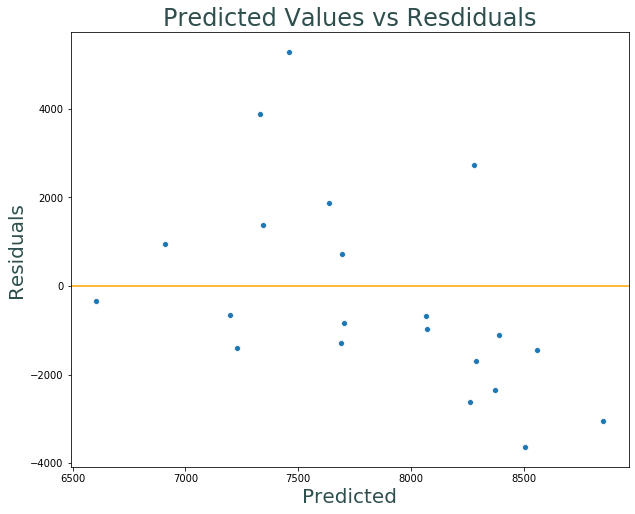

In [88]:
# Plot Predicted vs Residuals
xf=y_preds
yf=resd
#cf=graph['']
xlabel='Predicted'
ylabel='Residuals'
title = 'Predicted Values vs Resdiduals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(xf,yf,ci=None);
plt.axhline(0, color='orange');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

#### Scenerio - 3 Conclusion

#### Scenerio - 4
- use lag of rain data with 12 months and 24 months by adding and shifting rain_12 and rain_24 features
- remove original 'rain' feature since we will not have forecasted rain data in production
- add 'month' in addition to rain_12 and rain_24
- Remove outliers from crop data in train_val dataset


In [211]:
#For modeling from train and test datasets
dfi = df.copy()
dfi = dfi.set_index('date', drop=True) # set date as index
dfi = dfi[['rain','crop']].resample('M').sum() # resampling for monthly totals
dfi['rain'] = dfi['rain']/195 # removing rain multiplication by no of block (undoing the effect of melt)

dfi['month'] = dfi.index.month # adding new feature month

dfi['rain_12'] = dfi['rain'].shift(12) # creating new feature with shift by 12 months
dfi['rain_24'] = dfi['rain'].shift(24) # creating new feature with shift by 12 months

dfi.drop('rain',axis=1,inplace=True) # keeping only rain_12, rain_24 in train dataset as well.

dfi.dropna(inplace=True) # drop first 24 rows with null rain_24 column

# Train & Val : 1-apr-2011 to 31-Dec-2019
# Test : 1-Jan-2020 to 31-May-2020
dfi_m_train = dfi[dfi.index < '2020-01-01'].copy()# train & val dataset from 1-Apr-2011 to 31-Dec-2019

# remove outliers from Crop data in train & val 
dfi_m_train.drop(dfi_m_train[dfi_m_train['crop'] > 15000].index,inplace=True) 

dfi_m_test = dfi[dfi.index > '2019-12-31'].copy() # test dataset from 1-Jan-2020
dfi_m_test.drop(dfi_m_test[dfi_m_test.index > '2020-05-31'].index,inplace=True) # drop rows beyond 31st May 2020

dfi_m_test.drop('crop',axis=1,inplace=True) # drop target variable from test dataset

#remove date index from datasets for modeling 
dfi_m_train.reset_index(drop=True,inplace=True)
dfi_m_test.reset_index(drop=True,inplace=True)

# assign predictors and target variables
X = dfi_m_train[['month','rain_12','rain_24']]
y = dfi_m_train['crop']


# split train data into train and validation datasets
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.15,random_state=42)

# scaling predictors in train-val and test datasets
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train) 
X_val_scaled = ss.transform(X_val) 
test_scaled = ss.transform(dfi_m_test) # dataset for final test.

# instatiate Linear regression model 
lr4 = LinearRegression()
# fit the model on train dataset
lr4.fit(X_train_scaled, y_train)
# predict on val dataset
y_preds = lr4.predict(X_val_scaled)

#storing score 
scores_df = scores(scores_df,'Linear Regression lr4_S4','Train','R2',f'{round(lr4.score(X_train_scaled,y_train),4)}')
scores_df = scores(scores_df,'Linear Regression lr4_S4','Val','R2',f'{round(lr4.score(X_val_scaled,y_val),4)}')
scores_df = scores(scores_df,'Linear Regression lr4_S4','Val','Adj R2',f'{round((1-(1-r2_score(y_val, y_preds))*((len(X_val_scaled)-1)/(len(X_val_scaled)-len(X_val_scaled[0])-1))),4)}')
scores_df = scores(scores_df,'Linear Regression lr4_S4','train','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_train, lr4.predict(X_train_scaled))),2)}')
scores_df = scores(scores_df,'Linear Regression lr4_S4','Val','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_val, lr4.predict(X_val_scaled))),2)}')
scores_df = scores(scores_df,'Linear Regression lr4_S4','Val','CVal_3',f'{round(cross_val_score(lr4, X_val_scaled, y_val, cv=3).mean(),4)}')
scores_df.tail(6)

Model Type Dataset  Metric    Score
77  Linear Regression lr4_S4   Train      R2   0.0381
78  Linear Regression lr4_S4     Val      R2  -0.3092
79  Linear Regression lr4_S4     Val  Adj R2  -0.8002
80  Linear Regression lr4_S4   train    RMSE   1862.5
81  Linear Regression lr4_S4     Val    RMSE  1604.03
82  Linear Regression lr4_S4     Val  CVal_3   -3.841

#### Scenerio - 4 Evaluation

In [212]:
# residual of LR model on validation dataset
resd = y_val - y_preds
len(resd)

12

In [213]:
resd.mean()

-467.8701432445607

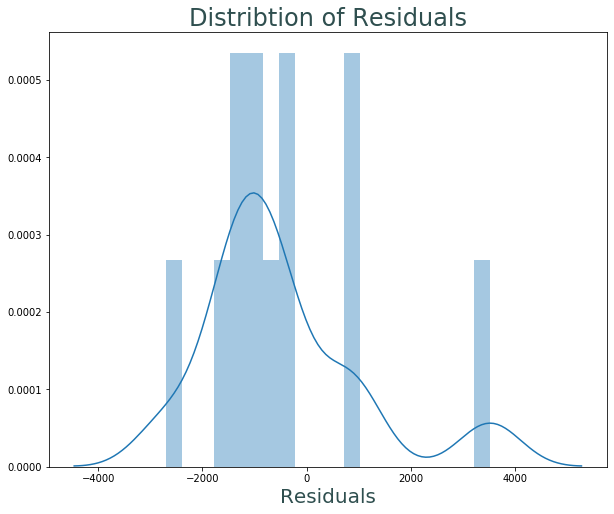

In [214]:
# Plot residuals
xf=resd
#yf=graph['crop']
#cf=graph['']
xlabel='Residuals'
ylabel='crop'
title = 'Distribtion of Residuals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.distplot(resd,bins=20);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
#ax.set_xticklabels(fontsize=my_ticks_font);
#ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

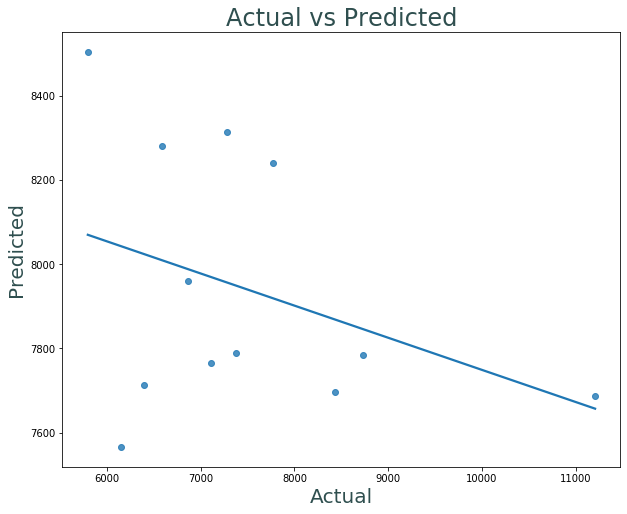

In [215]:
# Plot y_val and y_preds
xf=y_val
yf=y_preds
#cf=graph['']
xlabel='Actual'
ylabel='Predicted'
title = 'Actual vs Predicted'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.regplot(xf,yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

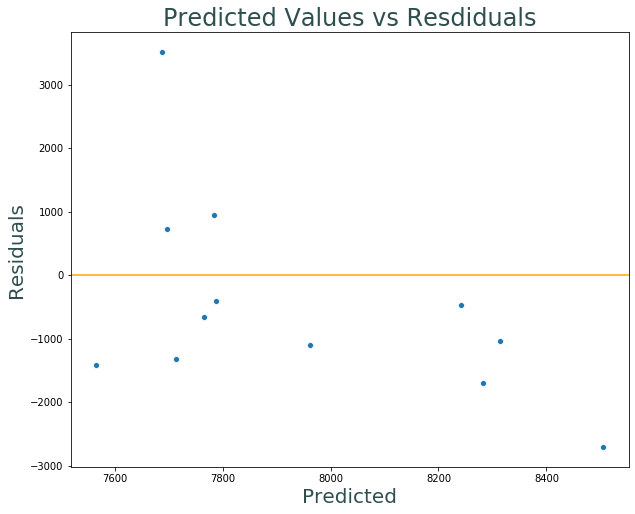

In [216]:
# Plot Predicted vs Residuals
xf=y_preds
yf=resd
#cf=graph['']
xlabel='Predicted'
ylabel='Residuals'
title = 'Predicted Values vs Resdiduals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(xf,yf,ci=None);
plt.axhline(0, color='orange');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

#### Scenerio - 4 Conclusion

### Linear Regression - Phase 2

'final_fused_monthly.csv' dataset includes month level crop and rain data for each block. 

To include the block in the monthly level data, following data transformation steps were executed:
- rain and crop data from various periods were concatenated.
- rain and block(only 'block' feature) datasets are merged to select only those blocks present in blocks dataset
- crop and block(only 'block' feature) datasets are merged to select only those blocks present in blocks dataset
- new rain & crop datasets are transposed to have date as one column and each blocks as one column
- new rain & crop datasets are resampled to have monthly summed rain and crop data for each block
- rain and crop dataset are melted to have one column for all blocks and all 'dates'(months) are repeated for each block.
- rain and crop are merged to have one final dataset with date(month),block,rain,crop.

#### Phase 2 Base Model

Phase 2 uses final_fused_monthly.csv which includes monthly rain and crop data at block level.

In [95]:
# compute mean of the traget variable 'crop'.
df = pd.read_csv("../data/final_fused_monthly.csv")
dfi = df.copy()
dfi['date'] = dfi['date'].apply(lambda x: str(x))
dfi = dfi.sort_values('date')
dfi = dfi.set_index('date', drop=True) # set date as index
dfi = dfi[dfi.index < '2020-01-01'] # train & val dataset

dfi['y_preds'] =  dfi['crop'] 
crop_mean = dfi['crop'].mean()
dfi['y_preds'] = dfi['y_preds'].apply(lambda x: crop_mean)

y_val = dfi['crop']
y_preds = dfi['y_preds']

print(f'Mean : {crop_mean}')
print(f'RMSE of Base Model:{math.sqrt(metrics.mean_squared_error(y_val,y_preds))}')
scores_df = scores(scores_df,'Linear Regression Base Model','train_val','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_val,y_preds)),2)}')



Mean : 41.827101586324716
RMSE of Base Model:25.34960725358291


#### Review Target variable Crop

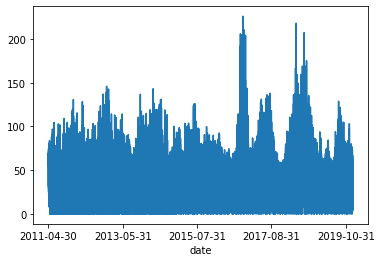

In [96]:
dfi['crop'].plot()

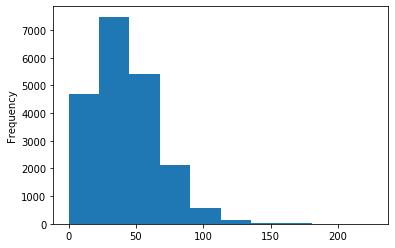

In [97]:
dfi['crop'].plot(kind='hist')

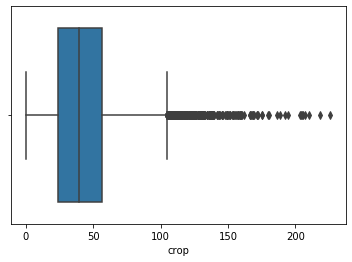

In [98]:
sns.boxplot(dfi['crop'],);

##### Analysis of Outliers and Zero values  in Crop Data  

In [99]:
dfi[dfi['crop'] > 100]['crop'].describe()
# there are only 450 rows (out of 21450) with crop more than 150 tonnes a month.

count    445.000000
mean     120.480539
std       22.199630
min      100.070260
25%      105.186880
50%      112.614640
75%      127.936830
max      225.925430
Name: crop, dtype: float64

In [100]:
dfi.groupby('blk')['crop'].describe()

count       mean        std       min       25%       50%       75%        max
blk                                                                                  
A01    105.0  38.261858  12.630390  13.29261  27.67634  38.90535  46.40696   77.11679
A02    105.0  38.452787  14.181463   7.49842  28.55806  37.77736  48.83897   77.83140
A03    105.0  41.865411  14.205845  10.82470  31.85342  42.67762  50.58973   81.38518
A04    105.0  43.717439  14.590103   8.10227  33.93287  44.30347  52.60424   85.16836
A05    105.0  43.934815  16.507385  12.94336  32.79522  42.73323  53.09358   97.06914
A06    105.0  44.438511  15.263282   9.93940  34.09597  44.41924  51.94358   84.61251
A07    105.0  30.565539  11.454934   8.55157  21.91535  29.56457  37.07224   76.24260
A08    105.0  45.737174  14.381270  10.94206  36.39471  44.02040  54.25096  109.36876
A09    105.0  46.503561  16.106081  10.75993  35.31734  45.24622  54.96652  114.63579
A10    105.0  46.826853  16.401942  10.42704  36.20956  45.29082  55.14601  115.36083
A100   105.0  40.061199  11.790584  17.70768  31.70356  40.31397  47.37280   81.54000
A101   105.0  37.760363  12.768638  17.40560  29.93588  36.46731  44.15192  114.66155
A102   105.0  18.464020   7.647868   6.38683  13.29411  17.25811  21.73917   56.59992
A11    105.0  47.061214  16.542388  10.68955  35.83010  44.43930  55.68602  102.31235
A12    105.0  45.292488  15.663682  10.61742  36.65218  42.80326  51.57529  101.45221
A13    105.0  48.734826  17.227664  12.79608  36.42279  47.09729  58.95804   97.28600
A14    105.0  49.509383  18.929384   9.69809  40.53036  47.57445  56.05159  108.60572
B01    105.0  64.252587  20.058186  23.23903  52.91073  63.60438  79.71064  123.44098
B02    105.0  63.400850  23.611059  15.11125  47.10221  60.71610  78.46119  156.40099
B03    105.0  67.590068  25.594255  16.08210  49.34796  65.50256  82.25230  168.93383
B04    105.0  70.376967  22.299057  27.57835  56.17472  65.81244  84.61711  148.60220
B05    105.0  68.302411  19.893159  24.44811  53.40634  67.92096  82.98079  130.52646
B06    105.0  76.082569  22.789964  32.64909  61.99758  73.25129  89.40013  158.45481
B07    105.0  66.099655  22.851168  27.07608  51.57546  64.05741  77.94882  174.95510
B08    105.0  27.560177   9.417864   6.51734  21.14948  26.84218  32.38081   61.30252
B09    105.0  50.679823  15.098315  19.53602  41.32404  50.36040  58.66800  103.68637
B10    105.0  65.777328  21.621033  24.57664  52.62581  63.06222  74.36350  151.06627
B100   105.0  66.734337  22.444967  28.53178  51.82976  63.58527  81.38596  143.50869
B101   105.0  59.615281  19.548438  26.30090  47.49716  56.90858  70.68653  158.86460
B102   105.0  40.383072  16.941046   9.79584  27.57405  38.57384  49.44439  110.41035
B106   105.0  15.811199  16.744445   2.75202   5.97452   8.37784  18.61499   95.80674
B11    105.0  63.986577  22.795595  15.60356  50.02807  60.51144  73.76475  151.68558
B12    105.0  62.927352  26.961079  13.12481  49.59982  59.93924  70.91692  207.12754
B13    105.0  66.780674  26.344598  13.67362  50.97748  64.92881  78.91742  179.32780
B14    105.0  69.150165  27.699128  15.71164  53.89515  66.73407  77.47158  194.80932
C01    105.0  59.210449  23.108487  21.16352  44.57718  56.15569  72.32149  210.46985
C02    105.0  59.294247  24.153017  25.97788  43.33251  54.95390  70.08334  203.09472
C03    105.0  55.032364  19.907357  15.17497  43.22823  51.43945  64.04624  157.75640
C04    105.0  54.485634  21.136682   9.05284  41.39903  51.18803  65.79075  149.36819
C05    105.0  56.270887  20.859366  17.45880  43.57344  52.20336  65.94691  160.74744
C06    105.0  55.983305  20.336461  18.70169  44.20421  52.60196  63.72341  167.47798
C07    105.0  56.211439  16.838834  19.05903  46.51197  52.95404  64.47972  123.92564
C08    105.0  54.728812  17.053049  22.96164  43.43671  50.96007  63.03925  132.02325
C09    105.0  58.147802  18.356517  23.86079  45.16760  54.49001  67.78855  125.72990
C10    105.0  34.597098  13.658201   7.91339  23.92

In [101]:
dfi.groupby('blk')['crop'].max().sort_values()

blk
E06        0.00000
E09        0.00000
ZC01B     10.55166
J03B      13.39512
J05C      15.86561
F07B      16.77460
E07B      18.96087
H02       20.09088
ZM102     20.31511
E08B      23.26277
I08B      24.32752
I01B      29.78423
J09       32.64769
H03B      34.56880
I09       39.31194
I06B      41.23245
E12       53.08940
ZO102     54.35970
A102      56.59992
J04B      58.18482
ZI01      59.07850
K09       61.08352
B08       61.30252
E100      61.97927
H106      63.46297
I07B      65.61117
I08       67.26297
I11       67.53946
J05B      68.35733
I10       68.60397
J08       69.51199
J04A      70.20209
I07A      70.79909
H12       73.67509
ZC102     73.73404
ZN102     74.02178
A07       76.24260
E102      76.48511
I06A      76.66058
A01       77.11679
A02       77.83140
ZJ01      79.12015
F103      79.30837
ZB102     79.56072
A03       81.38518
A100      81.54000
K05       81.62594
F12       82.83078
C10       83.18162
H07       83.54143
F10       83.75709
E01       84.27161
ZA01    

In [102]:
dfi[dfi['crop'] == 0]['blk'].unique()

array(['H02', 'H03B', 'E100', 'I01B', 'E09', 'E06', 'F05', 'F06', 'H10',
       'E05', 'J05C', 'ZC01B', 'E02', 'I08B', 'E01', 'E10', 'F07B'],
      dtype=object)

#### Scenerio - 5
- use lag of rain data with 6,12,24,26 months by adding and shifting rain_6,rain_12,rain_24 & rain_26 features
- remove original 'rain' feature since we will not have forecasted rain data in production
- add 'month' as new feature and one hot encode it.
- Remove outliers from crop data in train_val dataset
- Using the new fused dataset with blk information for monthly crop and rain, hot encode the block names 

In [103]:
#load final fused dataset
df = pd.read_csv("../data/final_fused_monthly.csv")
df['date'] = df['date'].apply(lambda x: str(x))
df['date'] = pd.to_datetime(df['date'],yearfirst=True,format="%Y/%m/%d")
df = pd.get_dummies(df, columns=['blk'],drop_first=False) # create one hot-encoded blocks
df['month'] = df['date'].dt.month # adding new feature month
df = pd.get_dummies(df, columns=['month'],drop_first=False) # create one hot-encoded months


df = df.sort_values('date')
dfi = df.copy()
dfi = dfi.set_index('date', drop=True) # set date as index
dfi['rain'] = dfi['rain']/195 # removing rain multiplication by no of block (undoing the effect of melt)

dfi['rain_6'] = dfi['rain'].shift(6) # creating new feature with shift by 6 months
dfi['rain_12'] = dfi['rain'].shift(12) # creating new feature with shift by 12 months
dfi['rain_24'] = dfi['rain'].shift(24) # creating new feature with shift by 24 months
dfi['rain_26'] = dfi['rain'].shift(26) # creating new feature with shift by 26 months


dfi.drop('rain',axis=1,inplace=True) # keeping only rain_12, rain_24 in train dataset as well.

dfi.dropna(inplace=True) # drop first 24 rows with null rain_24 column

# Train & Val : 1-apr-2011 to 31-Dec-2019
# Test : 1-Jan-2020 to 31-May-2020
dfi_m_train = dfi[dfi.index < '2020-01-01'].copy()# train & val dataset from 1-Apr-2011 to 31-Dec-2019

# Test dataset is used to apply finally seclected model
dfi_m_test = dfi[dfi.index > '2019-12-31'].copy() # test dataset from 1-Jan-2020
dfi_m_test.drop(dfi_m_test[dfi_m_test.index > '2020-05-31'].index,inplace=True) # drop rows beyond 31st May 2020
dfi_m_test.drop('crop',axis=1,inplace=True) # drop target variable from test dataset

#remove date index from datasets for modeling 
dfi_m_train.reset_index(drop=True,inplace=True)
dfi_m_test.reset_index(drop=True,inplace=True)

# assign predictors and target variables
X = dfi_m_train.drop(['crop'],axis=1)
y = dfi_m_train['crop']


# split train data into train and validation datasets
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.15,shuffle=False)

# scaling predictors in train-val and test datasets
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train) 
X_val_scaled = ss.transform(X_val) 
test_scaled = ss.transform(dfi_m_test) # dataset for final test.

# instatiate Linear regression model 
lr = LinearRegression()
# fit the model on train dataset
lr.fit(X_train_scaled, y_train)
# predict on val dataset
y_preds = lr.predict(X_val_scaled)

#storing score 
scores_df = scores(scores_df,'Linear Regression lr_S5','Train','R2',f'{round(lr.score(X_train_scaled,y_train),4)}')
scores_df = scores(scores_df,'Linear Regression lr_S5','Val','R2',f'{round(lr.score(X_val_scaled,y_val),4)}')
scores_df = scores(scores_df,'Linear Regression lr_S5','Val','Adj R2',f'{round((1-(1-r2_score(y_val, y_preds))*((len(X_val_scaled)-1)/(len(X_val_scaled)-len(X_val_scaled[0])-1))),4)}')
scores_df = scores(scores_df,'Linear Regression lr_S5','train','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_train, lr.predict(X_train_scaled))),2)}')
scores_df = scores(scores_df,'Linear Regression lr_S5','Val','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_val, lr.predict(X_val_scaled))),2)}')
scores_df = scores(scores_df,'Linear Regression lr_S5','train','CVal_5',f'{round(cross_val_score(lr, X_train_scaled, y_train, cv=5).mean(),4)}')
scores_df.tail(6)

Model Type Dataset  Metric   Score
26  Linear Regression lr_S5   Train      R2  0.5309
27  Linear Regression lr_S5     Val      R2   0.348
28  Linear Regression lr_S5     Val  Adj R2  0.2999
29  Linear Regression lr_S5   train    RMSE   17.87
30  Linear Regression lr_S5     Val    RMSE   16.29
31  Linear Regression lr_S5   train  CVal_5  0.4508

In [104]:
print(X_train.shape, len(y_train))
print(X_val.shape, len(y_val))

(17381, 211) 17381
(3068, 211) 3068


#### Scenerio - 5  Evaluation

In [105]:
# residual of LR model on validation dataset
resd = y_val - y_preds
len(resd)

3068

In [106]:
resd_perc = ((resd)/y_val)*100

In [107]:
y_val[y_val == 0].count()

46

In [108]:
y_preds

array([ 0.72300183, 19.85972058, 25.41245495, ..., 60.35306121,
        5.74368621, 65.73782684])

In [109]:
np.sort(resd)

array([-51.71845446, -48.05237559, -47.79346696, ...,  63.8934322 ,
        69.58776942,  71.48974755])

In [110]:
resd.mean()

-5.544115997446533

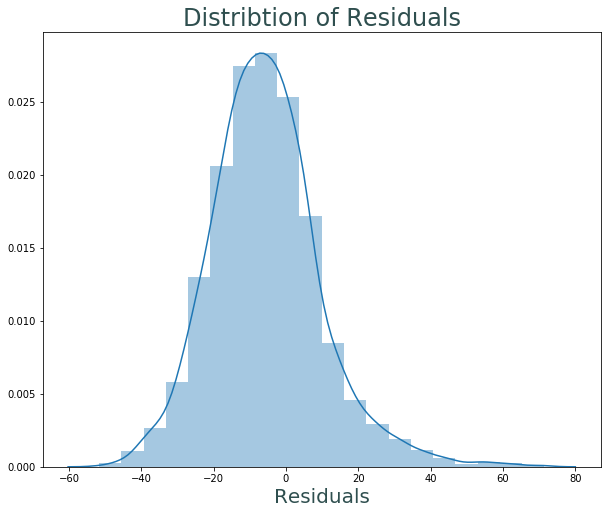

In [111]:
# Plot residuals
xf=resd
#yf=graph['crop']
#cf=graph['']
xlabel='Residuals'
ylabel='crop'
title = 'Distribtion of Residuals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.distplot(resd,bins=20);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
#ax.set_xticklabels(fontsize=my_ticks_font);
#ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

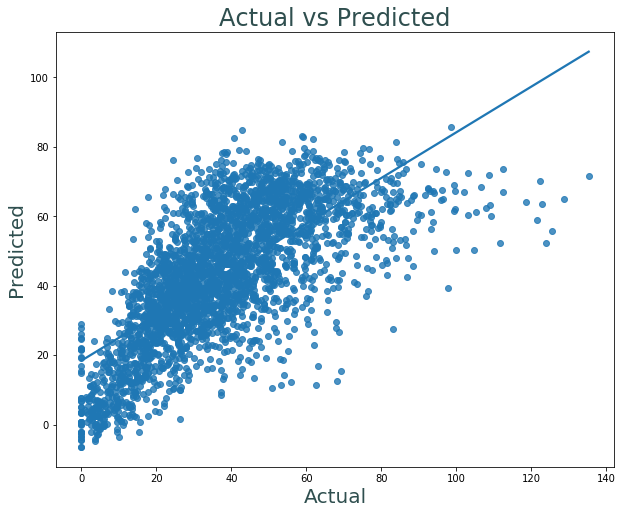

In [112]:
# Plot y_val and y_preds
xf=y_val
yf=y_preds
#cf=graph['']
xlabel='Actual'
ylabel='Predicted'
title = 'Actual vs Predicted'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.regplot(xf,yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

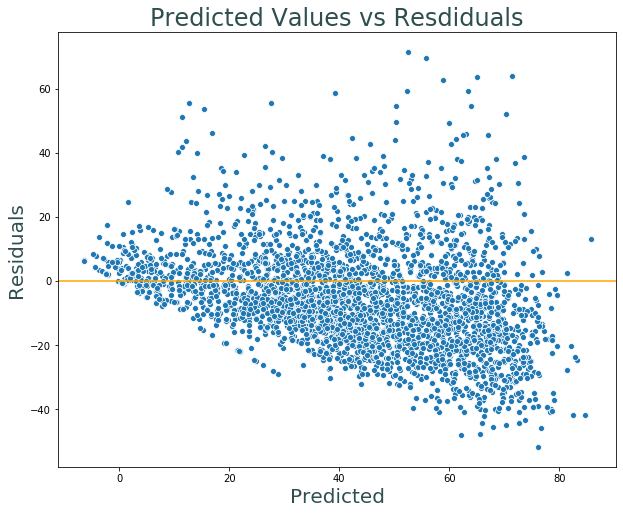

In [113]:
# Plot Predicted vs Residuals
xf=y_preds
yf=resd
#cf=graph['']
xlabel='Predicted'
ylabel='Residuals'
title = 'Predicted Values vs Resdiduals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(xf,yf,ci=None);
plt.axhline(0, color='orange');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

#### Scenerio - 5  Coef Analysis

In [114]:
lr.coef_

array([-1.99113742e+11, -1.99113742e+11, -1.97997690e+11, -1.97997690e+11,
       -1.97997690e+11, -1.97997690e+11, -1.97997690e+11, -1.99113742e+11,
       -1.99113742e+11, -1.99113742e+11, -1.99113742e+11, -1.99113742e+11,
       -1.99113742e+11, -1.99113742e+11, -1.99113742e+11, -1.99113742e+11,
       -2.00223444e+11, -2.00223444e+11, -2.00223444e+11, -2.00223444e+11,
       -1.99113742e+11, -1.99113742e+11, -2.00223444e+11, -1.99113742e+11,
       -2.00223444e+11, -2.00223444e+11, -2.00223444e+11, -1.97997690e+11,
       -1.99113742e+11, -1.99113742e+11, -2.00223444e+11, -2.00223444e+11,
       -1.99113742e+11, -1.99113742e+11, -1.99113742e+11, -2.00223444e+11,
       -1.99113742e+11, -1.99113742e+11, -1.99113742e+11, -1.99113742e+11,
       -1.99113742e+11, -1.99113742e+11, -1.99113742e+11, -2.00223444e+11,
       -1.99113742e+11, -2.00223444e+11, -2.00223444e+11, -2.00223444e+11,
       -1.99113742e+11, -1.99113742e+11, -1.99113742e+11, -1.99113742e+11,
       -1.99113742e+11, -

In [115]:
print(len(X_train.columns),len(lr.coef_))

211 211


In [116]:
features_coef = pd.DataFrame(lr.coef_, X_train.columns, columns=['Coeff'])

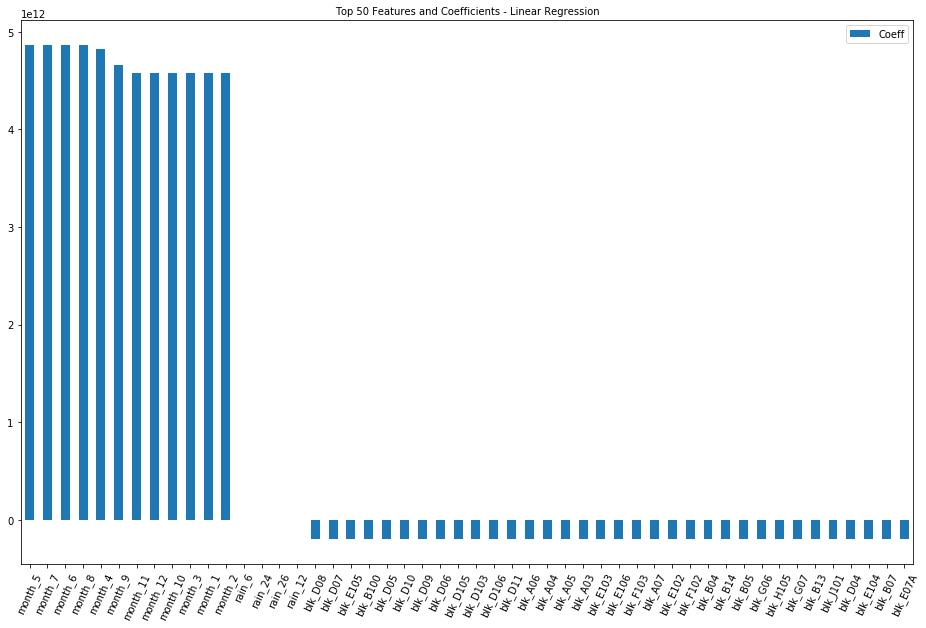

In [117]:
# top 50 features 
features_coef.sort_values('Coeff',ascending=False).head(50).plot(kind='bar',figsize=(16,10));
plt.title('Top 50 Features and Coefficients - Linear Regression',fontsize = 10);
plt.xticks(rotation=65);

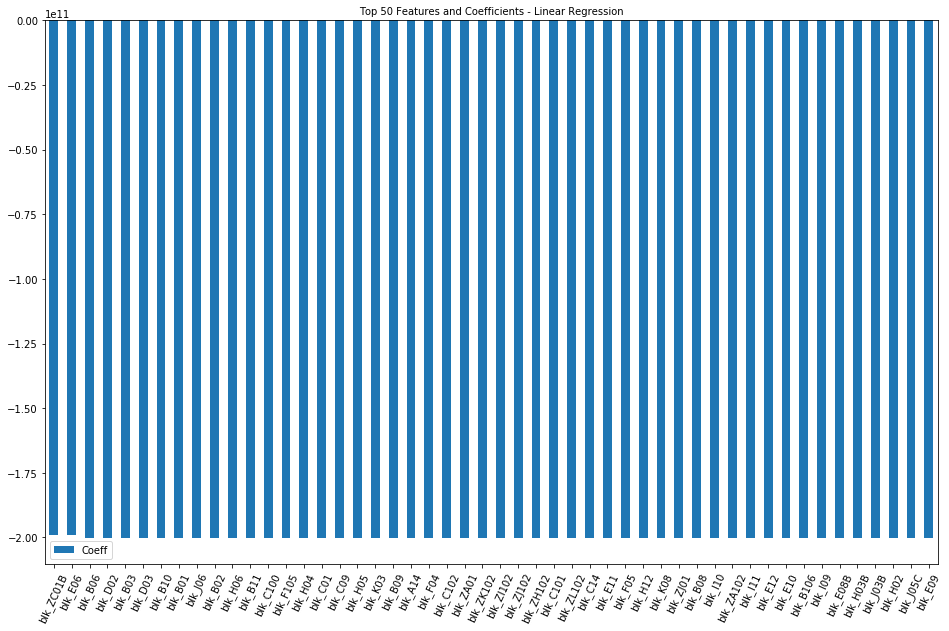

In [118]:
# bottom 50 features 
features_coef.sort_values('Coeff',ascending=False).tail(50).plot(kind='bar',figsize=(16,10));
plt.title('Top 50 Features and Coefficients - Linear Regression',fontsize = 10);
plt.xticks(rotation=65);

In [119]:
features_coef.tail(10)

Coeff
month_7   4.864030e+12
month_8   4.864030e+12
month_9   4.656641e+12
month_10  4.577837e+12
month_11  4.577837e+12
month_12  4.577837e+12
rain_6    2.080625e+00
rain_12  -2.988453e-01
rain_24   5.950378e-01
rain_26  -2.481666e-01

#### Scenerio - 5 Lasso Regression 

In [120]:
lassoCV = LassoCV(n_alphas=100,cv=5,verbose=0)
lassoCV.fit(X_train_scaled, y_train)
y_preds = lassoCV.predict(X_val_scaled)

scores_df = scores(scores_df,'Lasso lassoCV_S5','Train','R2',f'{round(lassoCV.score(X_train_scaled,y_train),4)}')
scores_df = scores(scores_df,'Lasso lassoCV_S5','Val','R2',f'{round(lassoCV.score(X_val_scaled,y_val),4)}')
scores_df = scores(scores_df,'Lasso lassoCV_S5','Val','Adj R2',f'{round((1-(1-r2_score(y_val, y_preds))*((len(X_val_scaled)-1)/(len(X_val_scaled)-len(X_val_scaled[0])-1))),4)}')
scores_df = scores(scores_df,'Lasso lassoCV_S5','train','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_train, lassoCV.predict(X_train_scaled))),2)}')
scores_df = scores(scores_df,'Lasso lassoCV_S5','Val','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_val, lassoCV.predict(X_val_scaled))),2)}')
#scores_df = scores(scores_df,'Lasso lassoCV_S5','train','CVal_5',f'{round(cross_val_score(lassoCV, X_train_scaled, y_train, cv=5).mean(),4)}')
scores_df.tail(5)

Model Type Dataset  Metric   Score
32  Lasso lassoCV_S5   Train      R2  0.5264
33  Lasso lassoCV_S5     Val      R2   0.378
34  Lasso lassoCV_S5     Val  Adj R2   0.332
35  Lasso lassoCV_S5   train    RMSE   17.96
36  Lasso lassoCV_S5     Val    RMSE   15.91

In [121]:
# residual of LR model on validation dataset
resd = y_val - y_preds
len(resd)

3068

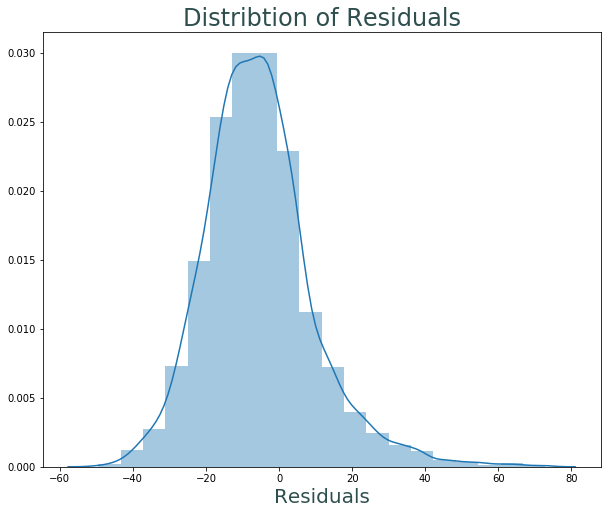

In [122]:
# Plot residuals
xf=resd
#yf=graph['crop']
#cf=graph['']
xlabel='Residuals'
ylabel='crop'
title = 'Distribtion of Residuals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.distplot(resd,bins=20);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
#ax.set_xticklabels(fontsize=my_ticks_font);
#ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

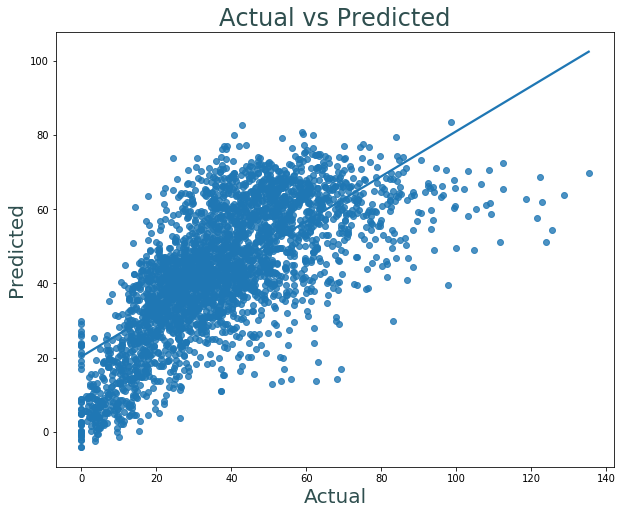

In [123]:
# Plot y_val and y_preds
xf=y_val
yf=y_preds
#cf=graph['']
xlabel='Actual'
ylabel='Predicted'
title = 'Actual vs Predicted'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.regplot(xf,yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

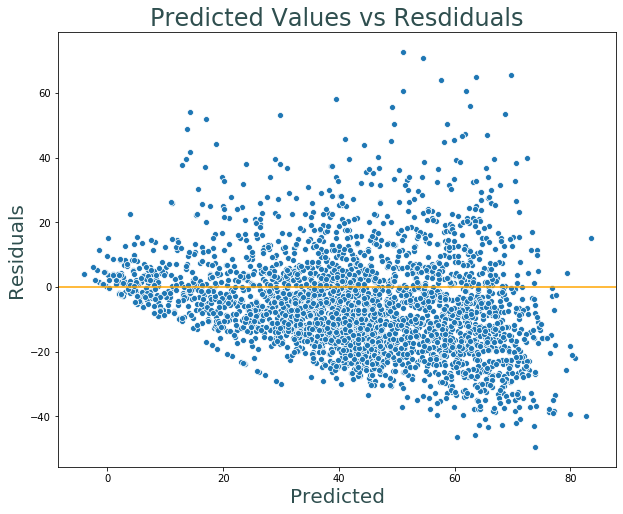

In [124]:
# Plot Predicted vs Residuals
xf=y_preds
yf=resd
#cf=graph['']
xlabel='Predicted'
ylabel='Residuals'
title = 'Predicted Values vs Resdiduals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(xf,yf,ci=None);
plt.axhline(0, color='orange');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

In [125]:
# Extracting the features with lassoCV.Coef_ value as zero
features_coef = pd.DataFrame(lassoCV.coef_, X_train.columns, columns=['Coeff'])
zero_coef = pd.DataFrame(features_coef[abs(features_coef['Coeff']) == 0])
print(zero_coef)
print('No. of features with zero lassoCV Coef :',len(pd.DataFrame(features_coef[abs(features_coef['Coeff']) == 0])))

           Coeff
blk_A03      0.0
blk_A05      0.0
blk_A100    -0.0
blk_B102    -0.0
blk_F08      0.0
blk_F09      0.0
blk_F11     -0.0
blk_H07     -0.0
blk_I06A    -0.0
blk_J05A     0.0
blk_ZS102   -0.0
month_10    -0.0
month_12     0.0
rain_12      0.0
rain_26      0.0
No. of features with zero lassoCV Coef : 15


In [126]:
zero_coef_list = zero_coef.index
zero_coef_list

Index(['blk_A03', 'blk_A05', 'blk_A100', 'blk_B102', 'blk_F08', 'blk_F09', 'blk_F11', 'blk_H07', 'blk_I06A', 'blk_J05A', 'blk_ZS102', 'month_10', 'month_12', 'rain_12', 'rain_26'], dtype='object')

In [127]:
# list of features with coef not equal to zero. 
selected_feat_coef = pd.DataFrame(features_coef[abs(features_coef['Coeff']) != 0]).sort_values('Coeff')
selected_feat_coef.count()

Coeff    196
dtype: int64

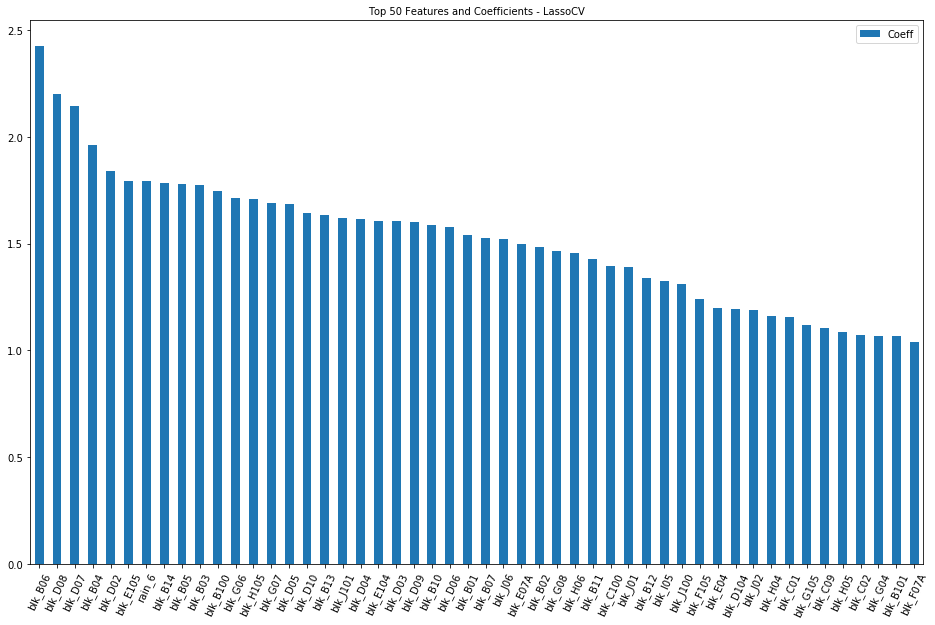

In [128]:
# top 50 features 
features_coef.sort_values('Coeff',ascending=False).head(50).plot(kind='bar',figsize=(16,10));
plt.title('Top 50 Features and Coefficients - LassoCV',fontsize = 10);
plt.xticks(rotation=65);

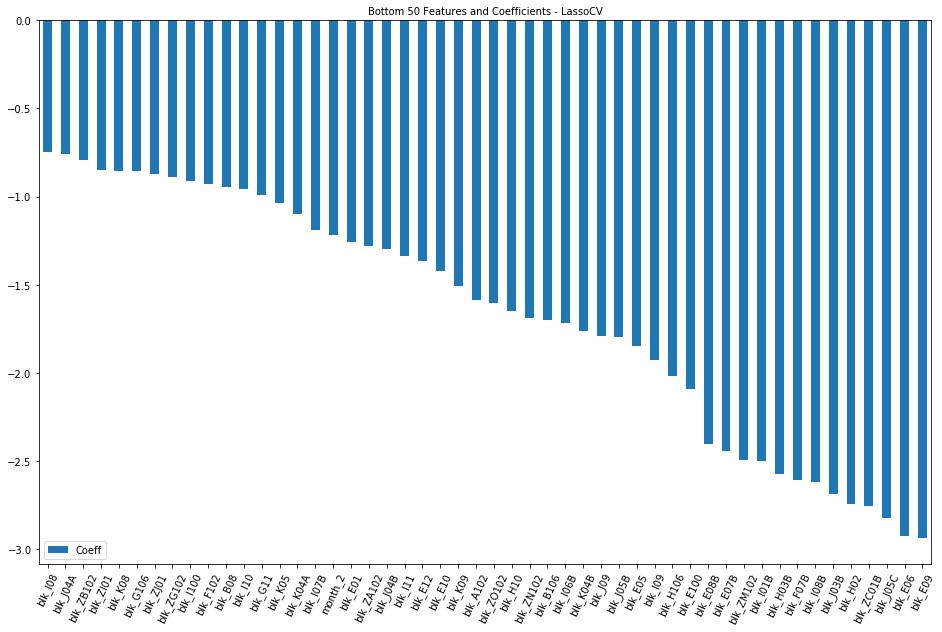

In [129]:
# bottom 50 features 
features_coef.sort_values('Coeff',ascending=False).tail(50).plot(kind='bar',figsize=(16,10));
plt.title('Bottom 50 Features and Coefficients - LassoCV',fontsize = 10);
plt.xticks(rotation=65);

In [130]:
features_coef.tail(10)

Coeff
month_7   0.128701
month_8  -0.366957
month_9  -0.737146
month_10 -0.000000
month_11  0.561025
month_12  0.000000
rain_6    1.791356
rain_12   0.000000
rain_24   0.197323
rain_26   0.000000

#### Scenerio - 6
- use lag of rain data with 6,12,24,26 months by adding and shifting rain_6,rain_12,rain_24 & rain_26 features
- remove original 'rain' feature since we will not have forecasted rain data in production
- add 'month' as new feature and one hot encode it.
- Remove outliers( crop greater than 127 tonnes per month) from crop data in train_val dataset
- Using the new fused dataset with blk information for monthly crop and rain, hot encode the block names 


In [131]:
#load final fused dataset
df = pd.read_csv("../data/final_fused_monthly.csv")
df['date'] = df['date'].apply(lambda x: str(x))
df['date'] = pd.to_datetime(df['date'],yearfirst=True,format="%Y/%m/%d")
df = pd.get_dummies(df, columns=['blk'],drop_first=False) # create one hot-encoded blocks
df['month'] = df['date'].dt.month # adding new feature month
df = pd.get_dummies(df, columns=['month'],drop_first=False) # create one hot-encoded months

df = df.sort_values('date')
dfi = df.copy()
dfi = dfi.set_index('date', drop=True) # set date as index

# rain data 
dfi['rain'] = dfi['rain']/195 # removing rain multiplication by no of block (undoing the effect of melt)
dfi['rain_6'] = dfi['rain'].shift(6) # creating new feature with shift by 6 months
dfi['rain_12'] = dfi['rain'].shift(12) # creating new feature with shift by 12 months
dfi['rain_24'] = dfi['rain'].shift(24) # creating new feature with shift by 24 months
dfi['rain_26'] = dfi['rain'].shift(26) # creating new feature with shift by 26 months
dfi.drop('rain',axis=1,inplace=True) # keeping only rain_12, rain_24 in train dataset as well.
dfi.dropna(inplace=True) # drop first 26 rows with null rain_26 column


# Train & Val : 1-apr-2011 to 31-Dec-2019
dfi_m_train = dfi[dfi.index < '2020-01-01'].copy()# train & val dataset from 1-Apr-2011 to 31-Dec-2019
# remove outliers from train_val dataset
dfi_m_train.drop(dfi_m_train[dfi_m_train['crop'] > 127].index,inplace=True)

# Test dataset is used to apply finally seclected model
dfi_m_test = dfi[dfi.index > '2019-12-31'].copy() # test dataset from 1-Jan-2020
dfi_m_test.drop(dfi_m_test[dfi_m_test.index > '2020-05-31'].index,inplace=True) # drop rows beyond 31st May 2020
dfi_m_test.drop('crop',axis=1,inplace=True) # drop target variable from test dataset

#remove date index from datasets for modeling 
dfi_m_train.reset_index(drop=True,inplace=True)
dfi_m_test.reset_index(drop=True,inplace=True)

# assign predictors and target variables
X = dfi_m_train.drop(['crop'],axis=1)
y = dfi_m_train['crop']

# split train data into train and validation datasets
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.15,shuffle=False)

# scaling predictors in train-val and test datasets
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train) 
X_val_scaled = ss.transform(X_val) 
test_scaled = ss.transform(dfi_m_test) # dataset for final test.

# instatiate Linear regression model 
lr = LinearRegression()
# fit the model on train dataset
lr.fit(X_train_scaled, y_train)
# predict on val dataset
y_preds = lr.predict(X_val_scaled)

#storing score 
scores_df = scores(scores_df,'Linear Regression lr_S6','Train','R2',f'{round(lr.score(X_train_scaled,y_train),4)}')
scores_df = scores(scores_df,'Linear Regression lr_S6','Val','R2',f'{round(lr.score(X_val_scaled,y_val),4)}')
scores_df = scores(scores_df,'Linear Regression lr_S6','Val','Adj R2',f'{round((1-(1-r2_score(y_val, y_preds))*((len(X_val_scaled)-1)/(len(X_val_scaled)-len(X_val_scaled[0])-1))),4)}')
scores_df = scores(scores_df,'Linear Regression lr_S6','train','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_train, lr.predict(X_train_scaled))),2)}')
scores_df = scores(scores_df,'Linear Regression lr_S6','Val','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_val, lr.predict(X_val_scaled))),2)}')
scores_df = scores(scores_df,'Linear Regression lr_S6','train','CVal_5',f'{round(cross_val_score(lr, X_train_scaled, y_train, cv=5).mean(),4)}')
scores_df.tail(6)


Model Type Dataset  Metric   Score
37  Linear Regression lr_S6   Train      R2  0.6165
38  Linear Regression lr_S6     Val      R2  0.4269
39  Linear Regression lr_S6     Val  Adj R2   0.373
40  Linear Regression lr_S6   train    RMSE   13.86
41  Linear Regression lr_S6     Val    RMSE    13.8
42  Linear Regression lr_S6   train  CVal_5  0.4951

In [132]:
print(X_train.shape, len(y_train))
print(X_val.shape, len(y_val))

(13900, 211) 13900
(2454, 211) 2454


#### Scenerio - 6  Evaluation

In [133]:
# residual of LR model on validation dataset
resd = y_val - y_preds
len(resd)

2454

###### residual of LR model on validation dataset
print(len(y_val),len(y_preds),len(df_val))
resd = y_val - y_preds
df_eval = df_val.copy()
df_eval['crop_preds'] = y_preds
df_eval['variance'] = (df_eval['crop'] - df_eval['crop_preds'])
df_eval[['date','blk_eval','crop','crop_preds','variance']].head()

graph = df_eval.groupby(['date'])[['crop','crop_preds']].sum()
##### Plot monthly estate level actaul vs predicted
xf=graph['crop']
yf=graph['crop_preds']
#cf=graph['']
xlabel='Actual'
ylabel='Predicted'
title = 'monthly Actual vs Predicted at Estate Level'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.regplot(xf,yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

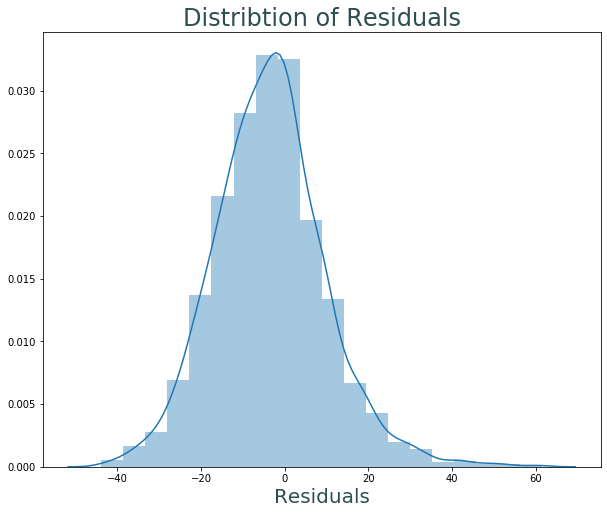

In [134]:
# Plot residuals
xf=resd
#yf=graph['crop']
#cf=graph['']
xlabel='Residuals'
ylabel='crop'
title = 'Distribtion of Residuals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.distplot(resd,bins=20);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
#ax.set_xticklabels(fontsize=my_ticks_font);
#ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

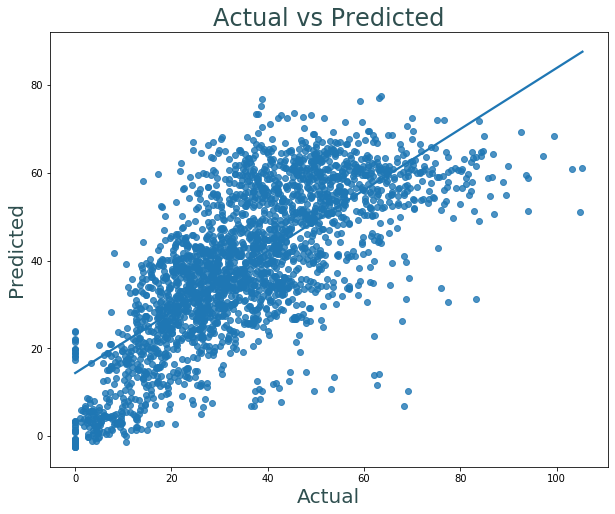

In [135]:
# Plot y_val and y_preds
xf=y_val
yf=y_preds
#cf=graph['']
xlabel='Actual'
ylabel='Predicted'
title = 'Actual vs Predicted'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.regplot(xf,yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

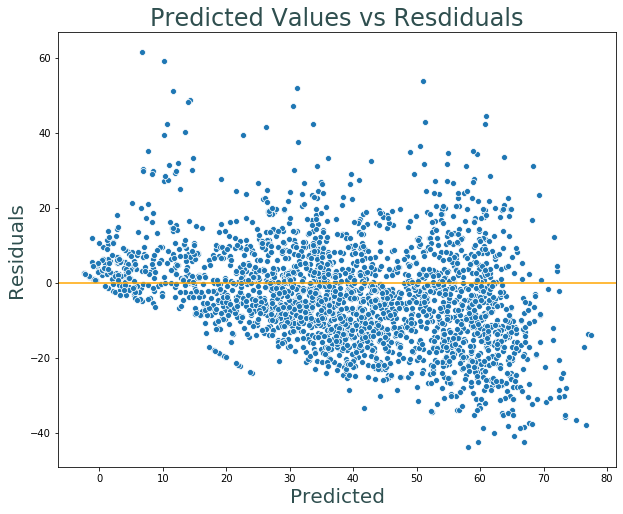

In [136]:
# Plot Predicted vs Residuals
xf=y_preds
yf=resd
#cf=graph['']
xlabel='Predicted'
ylabel='Residuals'
title = 'Predicted Values vs Resdiduals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(xf,yf,ci=None);
plt.axhline(0, color='orange');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

#### Scenerio- 6  Coef Analysis

In [137]:
#lr.coef_

In [138]:
print(len(X_train.columns),len(lr.coef_))

211 211


In [139]:
features_coef = pd.DataFrame(lr.coef_, X_train.columns, columns=['Coeff'])

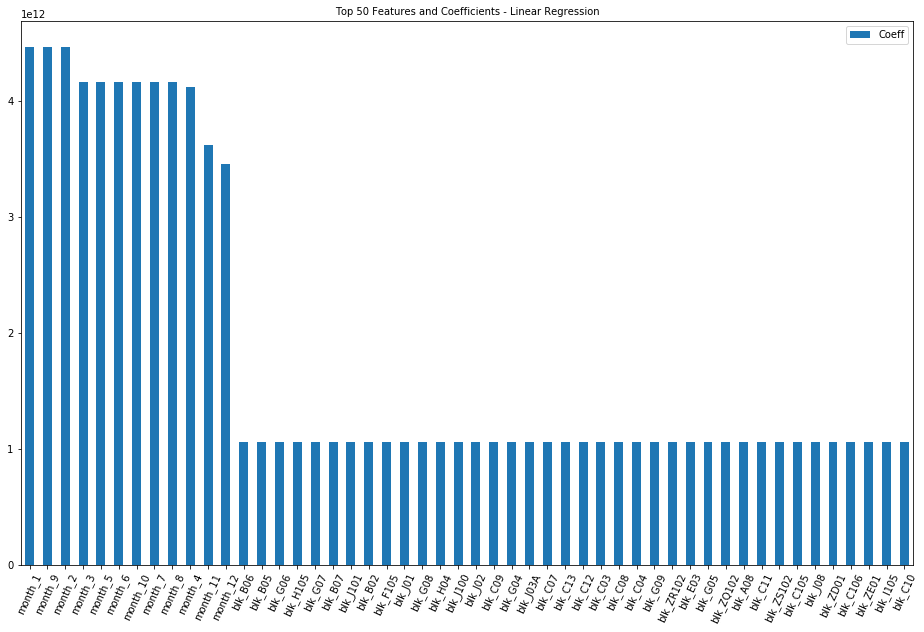

In [140]:
# top 50 features 
features_coef.sort_values('Coeff',ascending=False).head(50).plot(kind='bar',figsize=(16,10));
plt.title('Top 50 Features and Coefficients - Linear Regression',fontsize = 10);
plt.xticks(rotation=65);

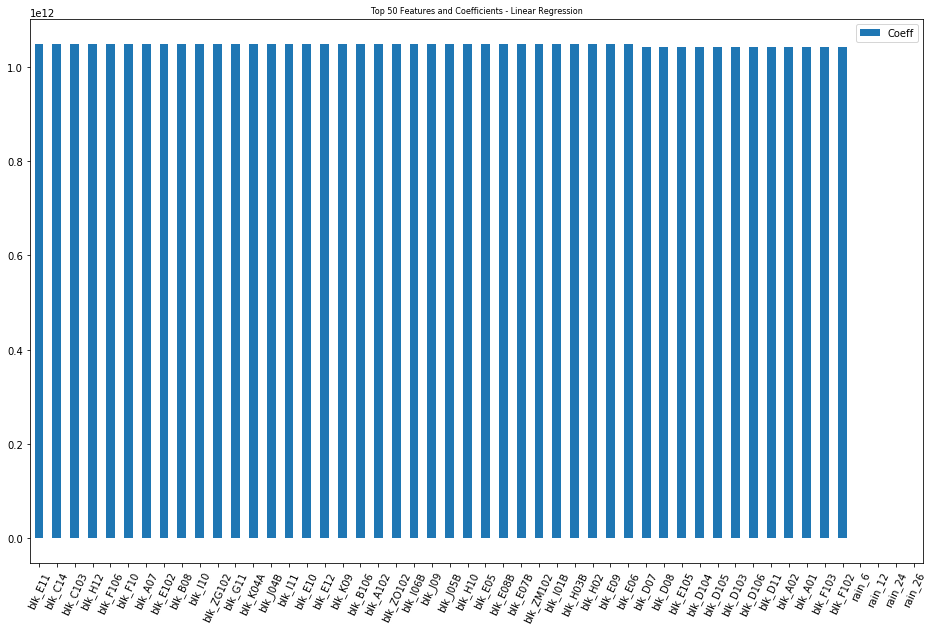

In [141]:
# bottom 50 features 
features_coef.sort_values('Coeff',ascending=False).tail(50).plot(kind='bar',figsize=(16,10));
plt.title('Top 50 Features and Coefficients - Linear Regression',fontsize = 8);
plt.xticks(rotation=65);

In [142]:
features_coef.tail(10)

Coeff
month_7   4.167737e+12
month_8   4.167737e+12
month_9   4.467058e+12
month_10  4.167737e+12
month_11  3.618402e+12
month_12  3.454676e+12
rain_6    3.331093e-01
rain_12   1.488165e-01
rain_24  -1.419380e-01
rain_26  -3.997226e-01

#### Scenerio - 6 Lasso Regression 

In [143]:
lassoCV = LassoCV(n_alphas=100,cv=5,verbose=0)
lassoCV.fit(X_train_scaled, y_train)
y_preds = lassoCV.predict(X_val_scaled)

scores_df = scores(scores_df,'Lasso lassoCV_S6','Train','R2',f'{round(lassoCV.score(X_train_scaled,y_train),4)}')
scores_df = scores(scores_df,'Lasso lassoCV_S6','Val','R2',f'{round(lassoCV.score(X_val_scaled,y_val),4)}')
scores_df = scores(scores_df,'Lasso lassoCV_S6','Val','Adj R2',f'{round((1-(1-r2_score(y_val, y_preds))*((len(X_val_scaled)-1)/(len(X_val_scaled)-len(X_val_scaled[0])-1))),4)}')
scores_df = scores(scores_df,'Lasso lassoCV_S6','train','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_train, lassoCV.predict(X_train_scaled))),2)}')
scores_df = scores(scores_df,'Lasso lassoCV_S6','Val','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_val, lassoCV.predict(X_val_scaled))),2)}')
#scores_df = scores(scores_df,'Lasso lassoCV_S6','train','CVal_5',f'{round(cross_val_score(lassoCV, X_train_scaled, y_train, cv=5).mean(),4)}')
scores_df.tail(5)


Model Type Dataset  Metric   Score
43  Lasso lassoCV_S6   Train      R2  0.6148
44  Lasso lassoCV_S6     Val      R2  0.4455
45  Lasso lassoCV_S6     Val  Adj R2  0.3934
46  Lasso lassoCV_S6   train    RMSE   13.89
47  Lasso lassoCV_S6     Val    RMSE   13.58

In [144]:
# residual of LR model on validation dataset
resd = y_val - y_preds
print(f'No. of resd:{len(resd)} No. of actuals {len(y_val)}')
display(y_val[0:5])
display(y_preds[0:5])

No. of resd:2454 No. of actuals 2454


13900    63.38119
13901    52.71568
13902    11.62971
13903    57.99105
13904    35.42728
Name: crop, dtype: float64

array([44.83758783, 50.28904017,  2.611005  , 58.17204647, 34.49826824])

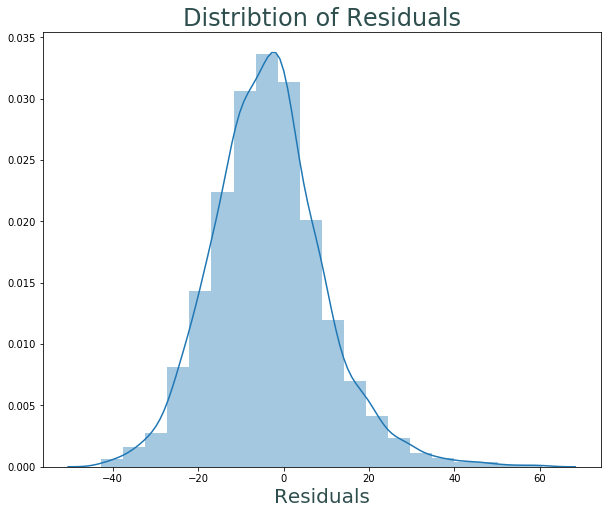

In [145]:
# Plot residuals
xf=resd
#yf=graph['crop']
#cf=graph['']
xlabel='Residuals'
ylabel='crop'
title = 'Distribtion of Residuals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.distplot(resd,bins=20);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
#ax.set_xticklabels(fontsize=my_ticks_font);
#ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

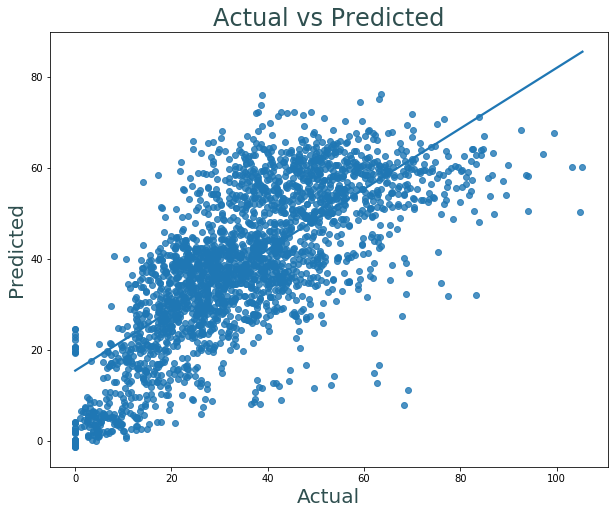

In [146]:
# Plot y_val and y_preds
xf=y_val
yf=y_preds
#cf=graph['']
xlabel='Actual'
ylabel='Predicted'
title = 'Actual vs Predicted'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.regplot(xf,yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

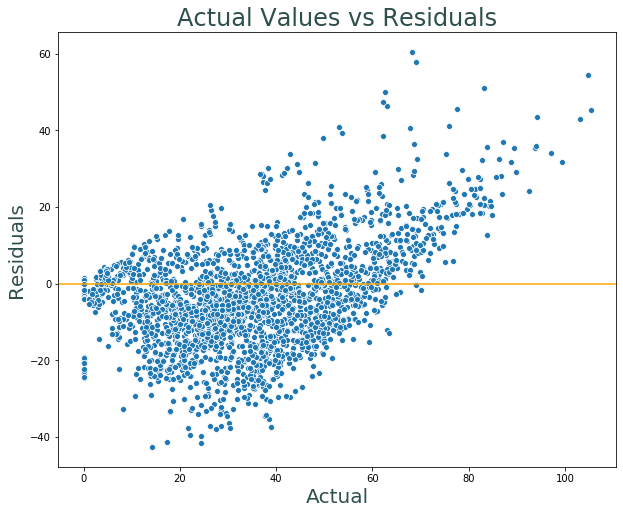

In [147]:
# Plot Actual vs Residuals
xf=y_val
yf=resd
#cf=graph['']
xlabel='Actual'
ylabel='Residuals'
title = 'Actual Values vs Residuals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(xf,yf,ci=None);
plt.axhline(0, color='orange');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

In [148]:
# Extracting the features with lassoCV.Coef_ value as zero
features_coef = pd.DataFrame(lassoCV.coef_, X_train.columns, columns=['Coeff'])
zero_coef = pd.DataFrame(features_coef[abs(features_coef['Coeff']) == 0])
print(zero_coef)
print('No. of features with zero lassoCV Coef :',len(pd.DataFrame(features_coef[abs(features_coef['Coeff']) == 0])))

          Coeff
blk_A100   -0.0
blk_F09     0.0
blk_H07     0.0
blk_J05A   -0.0
month_9    -0.0
month_12    0.0
rain_12     0.0
rain_24    -0.0
rain_26    -0.0
No. of features with zero lassoCV Coef : 9


In [149]:
zero_coef_list = zero_coef.index
zero_coef_list

Index(['blk_A100', 'blk_F09', 'blk_H07', 'blk_J05A', 'month_9', 'month_12', 'rain_12', 'rain_24', 'rain_26'], dtype='object')

In [150]:
# list of features with coef not equal to zero. 
selected_feat_coef = pd.DataFrame(features_coef[abs(features_coef['Coeff']) != 0]).sort_values('Coeff')
selected_feat_coef.count()

Coeff    202
dtype: int64

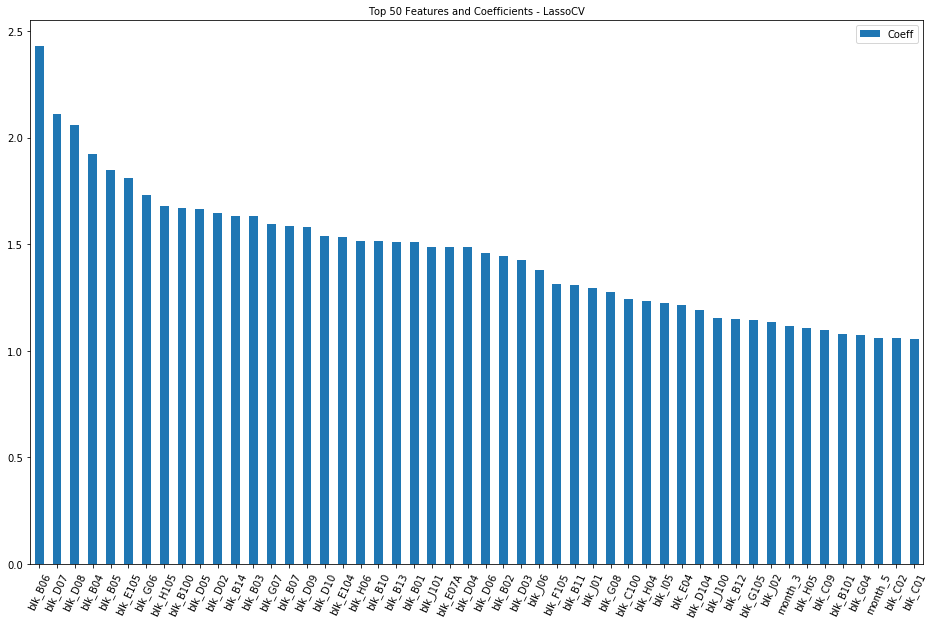

In [151]:
# top 50 features 
features_coef.sort_values('Coeff',ascending=False).head(50).plot(kind='bar',figsize=(16,10));
plt.title('Top 50 Features and Coefficients - LassoCV',fontsize = 10);
plt.xticks(rotation=65);

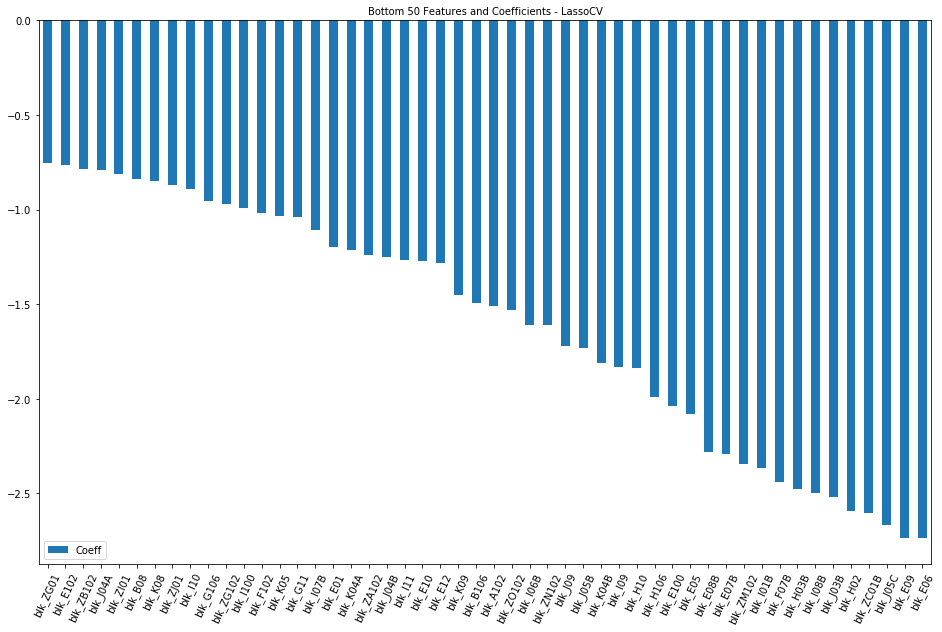

In [152]:
# bottom 50 features 
features_coef.sort_values('Coeff',ascending=False).tail(50).plot(kind='bar',figsize=(16,10));
plt.title('Bottom 50 Features and Coefficients - LassoCV',fontsize = 10);
plt.xticks(rotation=65);

In [217]:
features_coef.head(10)

Coeff
blk_A01 -0.187980
blk_A02 -0.177392
blk_A03 -0.000000
blk_A04  0.075728
blk_A05  0.000000
blk_A06  0.045319
blk_A07 -0.770678
blk_A08  0.153836
blk_A09  0.161343
blk_A10  0.182406

#### Scenerio - 7
- use lag of rain data with 6,12,24,26 months by adding and shifting rain_6,rain_12,rain_24 & rain_26 features
- remove original 'rain' feature since we will not have forecasted rain data in production
- add 'month' as new feature and one hot encode it.
- Remove outliers( crop greater than 127 tonnes per month) from crop data in train_val dataset
- Using the new fused dataset with blk information for monthly crop and rain, hot encode the block names 
- Remove observation with zero crop value

In [154]:
#load final fused dataset
df = pd.read_csv("../data/final_fused_monthly.csv")
df['date'] = df['date'].apply(lambda x: str(x))
df['date'] = pd.to_datetime(df['date'],yearfirst=True,format="%Y/%m/%d")
df = pd.get_dummies(df, columns=['blk'],drop_first=False) # create one hot-encoded blocks
df['month'] = df['date'].dt.month # adding new feature month
df = pd.get_dummies(df, columns=['month'],drop_first=False) # create one hot-encoded months

df = df.sort_values('date')
dfi = df.copy()
dfi = dfi.set_index('date', drop=True) # set date as index

# rain data 
dfi['rain'] = dfi['rain']/195 # removing rain multiplication by no of block (undoing the effect of melt)
dfi['rain_6'] = dfi['rain'].shift(6) # creating new feature with shift by 6 months
dfi['rain_12'] = dfi['rain'].shift(12) # creating new feature with shift by 12 months
dfi['rain_24'] = dfi['rain'].shift(24) # creating new feature with shift by 24 months
dfi['rain_26'] = dfi['rain'].shift(26) # creating new feature with shift by 26 months
dfi.drop('rain',axis=1,inplace=True) # keeping only rain_12, rain_24 in train dataset as well.
dfi.dropna(inplace=True) # drop first 26 rows with null rain_26 column

# Train & Val : 1-apr-2011 to 31-Dec-2019
dfi_m_train = dfi[dfi.index < '2020-01-01'].copy()# train & val dataset from 1-Apr-2011 to 31-Dec-2019
# remove outliers from train_val dataset
dfi_m_train.drop(dfi_m_train[dfi_m_train['crop'] > 127].index,inplace=True)

# Test dataset is used to apply finally seclected model
dfi_m_test = dfi[dfi.index > '2019-12-31'].copy() # test dataset from 1-Jan-2020
dfi_m_test.drop(dfi_m_test[dfi_m_test.index > '2020-05-31'].index,inplace=True) # drop rows beyond 31st May 2020

#remove date index from datasets for modeling 
dfi_m_train.reset_index(drop=True,inplace=True)
dfi_m_test.reset_index(drop=True,inplace=True)

#remove rows with zero crop
dfi_m_train.drop(dfi_m_train[dfi_m_train['crop'] == 0].index,inplace=True)
dfi_m_test.drop(dfi_m_test[dfi_m_test['crop'] == 0].index,inplace=True)

# remove label data - crop from final test dataset
dfi_m_test.drop('crop',axis=1,inplace=True) # drop target variable from test dataset

# assign predictors and target variables
X = dfi_m_train.drop(['crop'],axis=1)
y = dfi_m_train['crop']

# split train data into train and validation datasets
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.15,shuffle=False)

# scaling predictors in train-val and test datasets
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train) 
X_val_scaled = ss.transform(X_val) 
test_scaled = ss.transform(dfi_m_test) # dataset for final test.

# instatiate Linear regression model 
lr = LinearRegression()
# fit the model on train dataset
lr.fit(X_train_scaled, y_train)
# predict on val dataset
y_preds = lr.predict(X_val_scaled)

#storing score 
scores_df = scores(scores_df,'Linear Regression lr_S5','Train','R2',f'{round(lr.score(X_train_scaled,y_train),4)}')
scores_df = scores(scores_df,'Linear Regression lr_S5','Val','R2',f'{round(lr.score(X_val_scaled,y_val),4)}')
scores_df = scores(scores_df,'Linear Regression lr_S5','Val','Adj R2',f'{round((1-(1-r2_score(y_val, y_preds))*((len(X_val_scaled)-1)/(len(X_val_scaled)-len(X_val_scaled[0])-1))),4)}')
scores_df = scores(scores_df,'Linear Regression lr_S5','train','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_train, lr.predict(X_train_scaled))),2)}')
scores_df = scores(scores_df,'Linear Regression lr_S5','Val','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_val, lr.predict(X_val_scaled))),2)}')
scores_df = scores(scores_df,'Linear Regression lr_S5','train','CVal_5',f'{round(cross_val_score(lr, X_train_scaled, y_train, cv=5).mean(),4)}')
scores_df.tail(6)



Model Type Dataset  Metric   Score
48  Linear Regression lr_S5   Train      R2  0.5949
49  Linear Regression lr_S5     Val      R2  0.3989
50  Linear Regression lr_S5     Val  Adj R2  0.3401
51  Linear Regression lr_S5   train    RMSE   13.62
52  Linear Regression lr_S5     Val    RMSE    13.8
53  Linear Regression lr_S5   train  CVal_5  0.4644

#### Scenerio - 7  Evaluation

In [155]:
# residual of LR model on validation dataset
resd = y_val - y_preds
len(resd)

2369

In [156]:
resd_perc = ((resd)/y_val)*100

In [157]:
display(y_val[0:10])
display(y_preds[0:10])

13948    49.66056
13949    44.46350
13950    27.92843
13951     4.01984
13952    21.05549
13953    38.26443
13954    39.99068
13955    18.83282
13956    56.84319
13957    47.39119
Name: crop, dtype: float64

array([21.21092366, 57.00779866, 24.30467366,  1.47654866, 28.36717366,
       29.57029866, 44.85154866, 18.30467366, 33.17967366, 40.08592366])

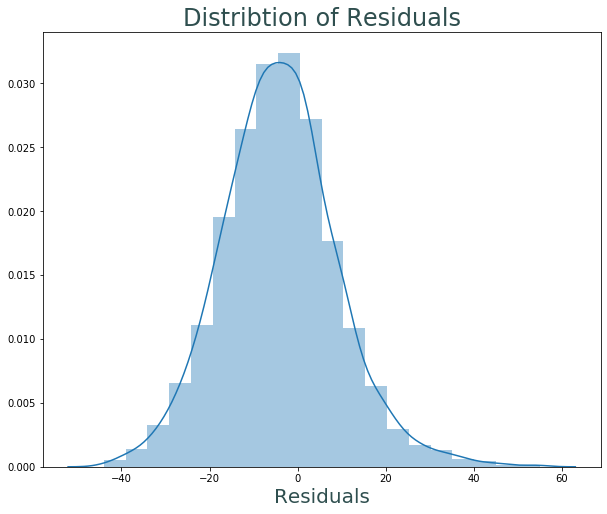

In [158]:
# Plot residuals
xf=resd
#yf=graph['crop']
#cf=graph['']
xlabel='Residuals'
ylabel='crop'
title = 'Distribtion of Residuals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.distplot(resd,bins=20);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
#ax.set_xticklabels(fontsize=my_ticks_font);
#ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

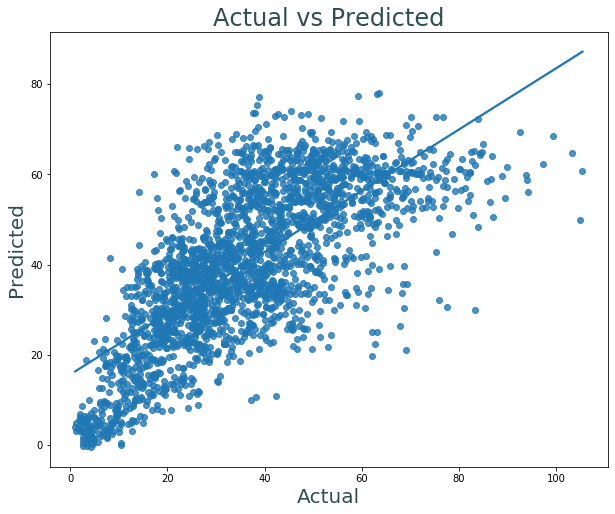

In [159]:
# Plot y_val and y_preds
xf=y_val
yf=y_preds
#cf=graph['']
xlabel='Actual'
ylabel='Predicted'
title = 'Actual vs Predicted'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.regplot(xf,yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

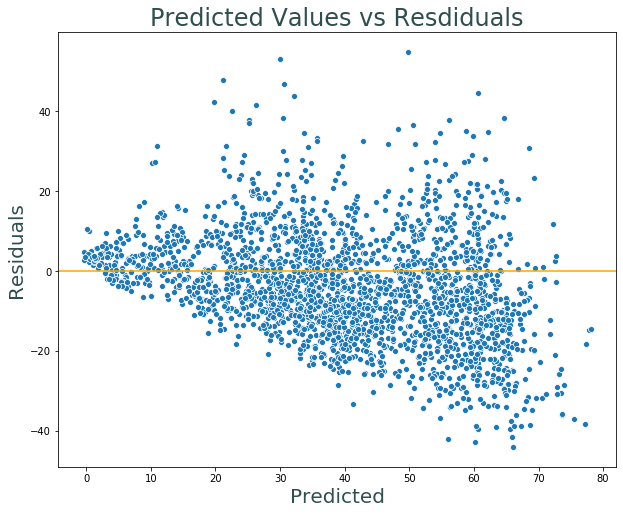

In [160]:
# Plot Predicted vs Residuals
xf=y_preds
yf=resd
#cf=graph['']
xlabel='Predicted'
ylabel='Residuals'
title = 'Predicted Values vs Resdiduals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(xf,yf,ci=None);
plt.axhline(0, color='orange');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

#### Scenerio- 7  Coef Analysis

In [161]:
#lr.coef_

In [162]:
print(len(X_train.columns),len(lr.coef_))

211 211


In [163]:
features_coef = pd.DataFrame(lr.coef_, X_train.columns, columns=['Coeff'])

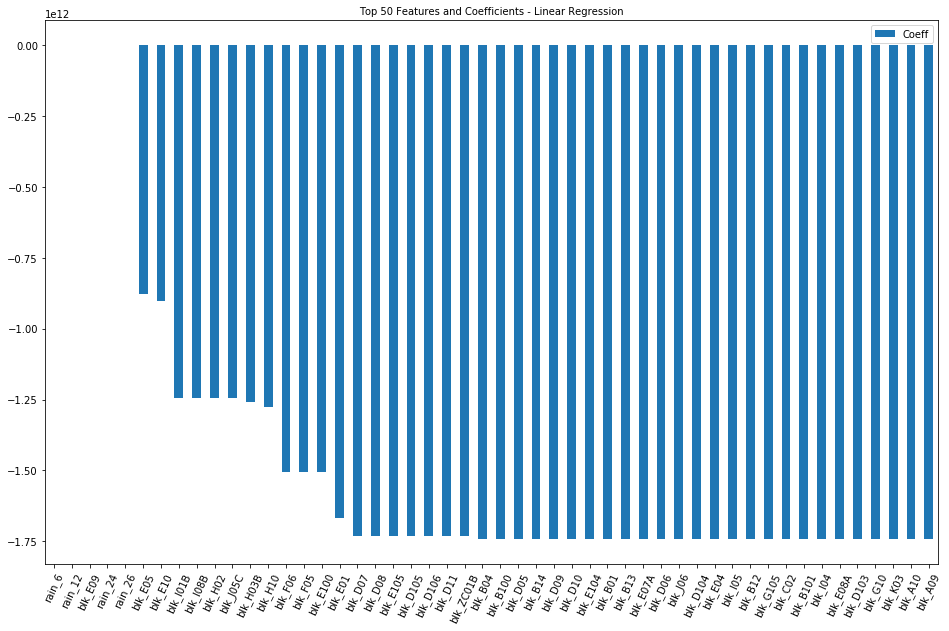

In [164]:
# top 50 features 
features_coef.sort_values('Coeff',ascending=False).head(50).plot(kind='bar',figsize=(16,10));
plt.title('Top 50 Features and Coefficients - Linear Regression',fontsize = 10);
plt.xticks(rotation=65);

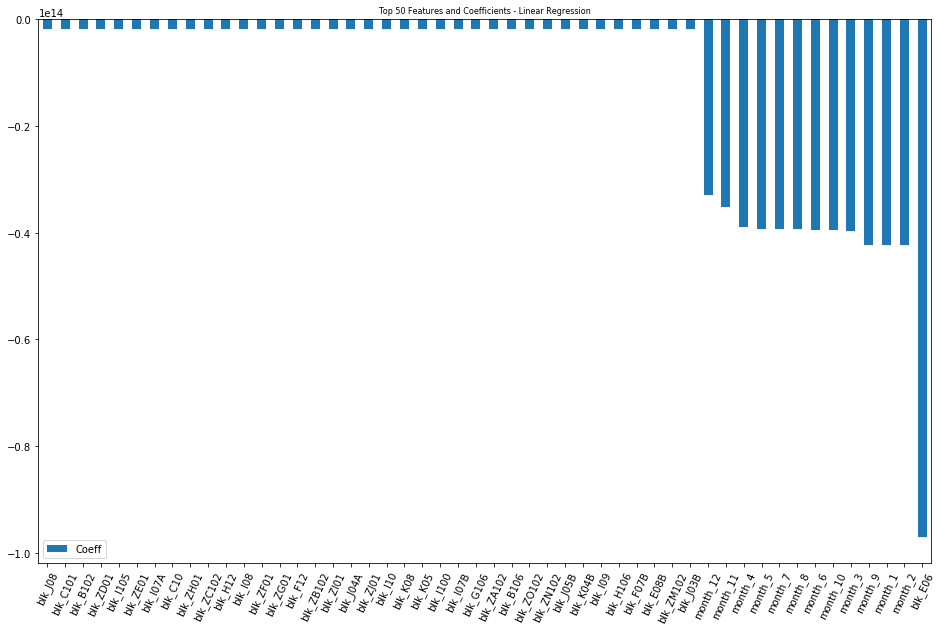

In [165]:
# bottom 50 features 
features_coef.sort_values('Coeff',ascending=False).tail(50).plot(kind='bar',figsize=(16,10));
plt.title('Top 50 Features and Coefficients - Linear Regression',fontsize = 8);
plt.xticks(rotation=65);

In [166]:
features_coef.tail(10)

Coeff
month_7  -3.933710e+13
month_8  -3.933710e+13
month_9  -4.226196e+13
month_10 -3.951247e+13
month_11 -3.525431e+13
month_12 -3.286081e+13
rain_6    4.389908e-01
rain_12   1.105297e-01
rain_24  -5.990458e-02
rain_26  -5.713673e-01

#### Scenerio - 7 Lasso Regression 

In [167]:
lassoCV = LassoCV(n_alphas=100,cv=5,verbose=0)
lassoCV.fit(X_train_scaled, y_train)
y_preds = lassoCV.predict(X_val_scaled)

scores_df = scores(scores_df,'Lasso lassoCV_S7','Train','R2',f'{round(lassoCV.score(X_train_scaled,y_train),4)}')
scores_df = scores(scores_df,'Lasso lassoCV_S7','Val','R2',f'{round(lassoCV.score(X_val_scaled,y_val),4)}')
scores_df = scores(scores_df,'Lasso lassoCV_S7','Val','Adj R2',f'{round((1-(1-r2_score(y_val, y_preds))*((len(X_val_scaled)-1)/(len(X_val_scaled)-len(X_val_scaled[0])-1))),4)}')
scores_df = scores(scores_df,'Lasso lassoCV_S7','train','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_train, lassoCV.predict(X_train_scaled))),2)}')
scores_df = scores(scores_df,'Lasso lassoCV_S7','Val','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_val, lassoCV.predict(X_val_scaled))),2)}')
#scores_df = scores(scores_df,'Lasso lassoCV_S7','train','CVal_5',f'{round(cross_val_score(lassoCV, X_train_scaled, y_train, cv=5).mean(),4)}')
scores_df.tail(5)


Model Type Dataset  Metric   Score
54  Lasso lassoCV_S7   Train      R2  0.5956
55  Lasso lassoCV_S7     Val      R2  0.4292
56  Lasso lassoCV_S7     Val  Adj R2  0.3734
57  Lasso lassoCV_S7   train    RMSE   13.61
58  Lasso lassoCV_S7     Val    RMSE   13.45

In [168]:
# residual of LR model on validation dataset
resd = y_val - y_preds
print(f'No. of resd:{len(resd)} No. of actuals {len(y_val)}')
display(y_val[0:5])
display(y_preds[0:5])

No. of resd:2369 No. of actuals 2369


13948    49.66056
13949    44.46350
13950    27.92843
13951     4.01984
13952    21.05549
Name: crop, dtype: float64

array([22.84615524, 56.72021301, 25.58655046,  3.18578064, 29.38929444])

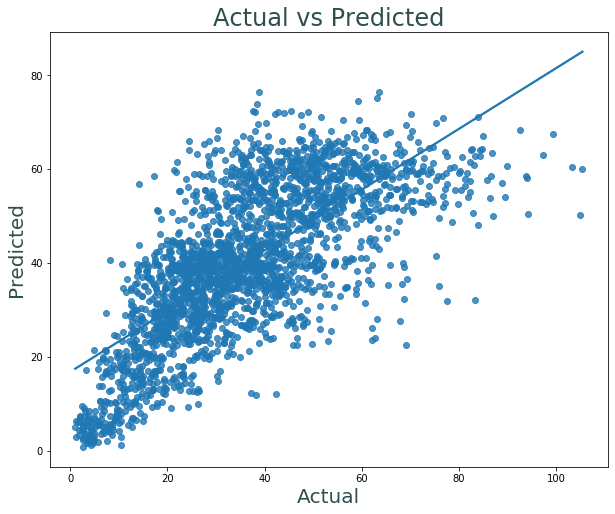

In [169]:
# Plot y_val and y_preds
xf=y_val
yf=y_preds
#cf=graph['']
xlabel='Actual'
ylabel='Predicted'
title = 'Actual vs Predicted'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.regplot(xf,yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

In [170]:
# Extracting the features with lassoCV.Coef_ value as zero
features_coef = pd.DataFrame(lassoCV.coef_, X_train.columns, columns=['Coeff'])
zero_coef = pd.DataFrame(features_coef[abs(features_coef['Coeff']) == 0])
print(zero_coef)
print('No. of features with zero lassoCV Coef :',len(pd.DataFrame(features_coef[abs(features_coef['Coeff']) == 0])))

           Coeff
blk_A03     -0.0
blk_A05      0.0
blk_D11      0.0
blk_E06      0.0
blk_E09      0.0
blk_F05      0.0
blk_H07     -0.0
blk_I06A    -0.0
blk_ZF102    0.0
month_9     -0.0
month_12     0.0
rain_6       0.0
rain_12      0.0
rain_24     -0.0
No. of features with zero lassoCV Coef : 14


In [171]:
zero_coef_list = zero_coef.index
zero_coef_list

Index(['blk_A03', 'blk_A05', 'blk_D11', 'blk_E06', 'blk_E09', 'blk_F05', 'blk_H07', 'blk_I06A', 'blk_ZF102', 'month_9', 'month_12', 'rain_6', 'rain_12', 'rain_24'], dtype='object')

In [172]:
# list of features with coef not equal to zero. 
selected_feat_coef = pd.DataFrame(features_coef[abs(features_coef['Coeff']) != 0]).sort_values('Coeff')
selected_feat_coef.count()

Coeff    197
dtype: int64

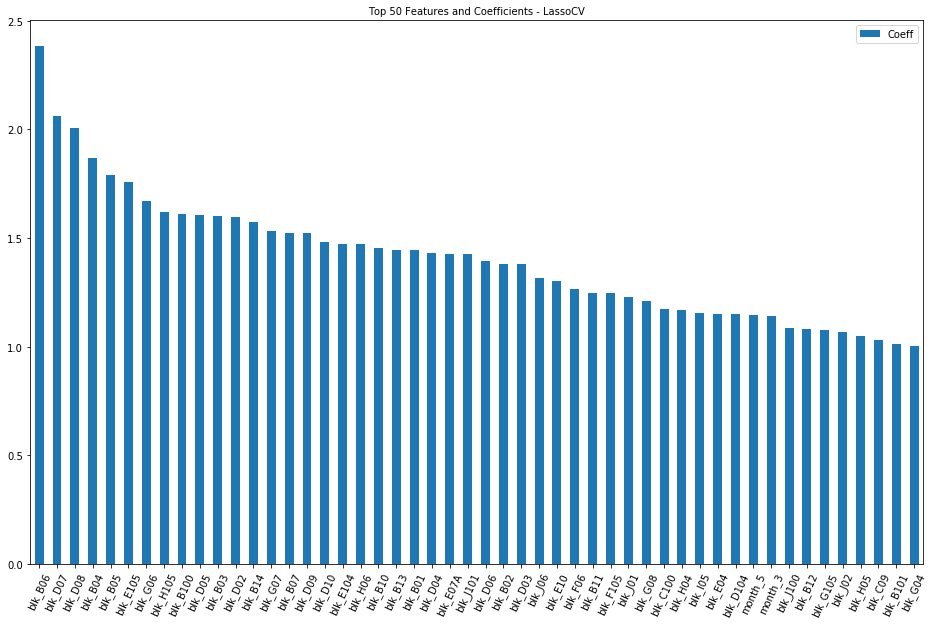

In [173]:
# top 50 features 
features_coef.sort_values('Coeff',ascending=False).head(50).plot(kind='bar',figsize=(16,10));
plt.title('Top 50 Features and Coefficients - LassoCV',fontsize = 10);
plt.xticks(rotation=65);

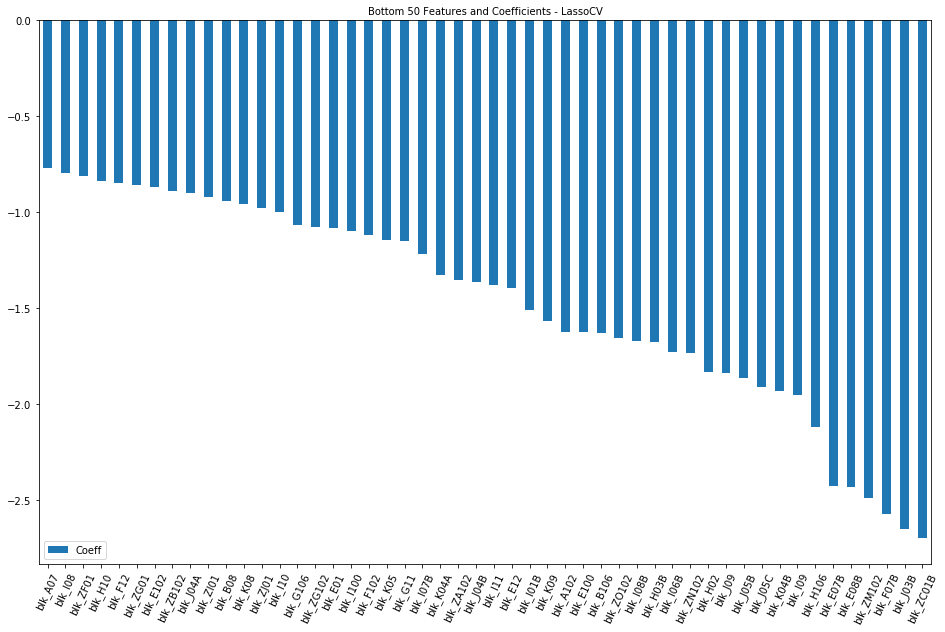

In [174]:
# bottom 50 features 
features_coef.sort_values('Coeff',ascending=False).tail(50).plot(kind='bar',figsize=(16,10));
plt.title('Bottom 50 Features and Coefficients - LassoCV',fontsize = 10);
plt.xticks(rotation=65);

In [175]:
features_coef.tail(10)

Coeff
month_7  -0.391346
month_8  -0.596681
month_9  -0.000000
month_10 -0.164960
month_11 -0.260319
month_12  0.000000
rain_6    0.000000
rain_12   0.000000
rain_24  -0.000000
rain_26  -0.010466

#### Scenerio - 9

- use lag of rain data with 6,12,24,26 months by adding and shifting rain_6,rain_12,rain_24 & rain_26 features
- remove original 'rain' feature since we will not have forecasted rain data in production
- add 'month' as new feature and one hot encode it.
- Remove outliers( crop greater than 127 tonnes per month) from crop data in train_val dataset
- Using the new fused dataset with blk information for monthly crop and rain, hot encode the block names 
- not removing observations with zero crop
- Use area, no of palms, age, class proportion
- compute age as of the month of the each crop data observation

In [218]:
#load final fused dataset
blocks = pd.read_csv("../data/blocks.csv")
df = pd.read_csv("../data/final_fused_monthly.csv")
df['date'] = df['date'].apply(lambda x: str(x))
df['date'] = pd.to_datetime(df['date'],yearfirst=True,format="%Y/%m/%d")

# merge with blocks to get block's static features
df = pd.merge(df, blocks,
                how='left', 
                left_on = 'blk', 
                right_on = 'blk', 
                copy=False)


df['mth_of_plant'] = df['mth_of_plant'].apply(lambda x: str(x))
df['mth_of_plant'] = pd.to_datetime(df['mth_of_plant'],yearfirst=True,format="%Y/%m/%d")
    
# compute age as of the month year and month of the crop.
for i in df.index:
    difference = relativedelta.relativedelta(pd.to_datetime(df.loc[i]['date']), 
                                             pd.to_datetime(df.loc[i]['mth_of_plant']))
    months = difference.years * 12 + difference.months
    df.at[i,'age'] = months

#Drop features not required for modeling 
df.drop(['plant_mat','mth_of_plant','syp1_ha','syp2_ha','syp3_ha', 'syp4_ha','syp5_ha','density'],
        axis=1,inplace=True)

# create one hot-encoded blocks
df['blk_eval'] = df['blk'] # keep copy of block name for evaluation of the model
df = pd.get_dummies(df, columns=['blk'],drop_first=False) 

# add new feature month
df['month'] = df['date'].dt.month 
df = pd.get_dummies(df, columns=['month'],drop_first=False) # create one hot-encoded months

df = df.sort_values('date')
dfi = df.copy()
dfi = dfi.set_index('date', drop=True) # set date as index

# rain data 
dfi['rain'] = dfi['rain']/195 # removing rain multiplication by no of block (undoing the effect of melt)
dfi['rain_6'] = dfi['rain'].shift(6) # creating new feature with shift 
dfi['rain_12'] = dfi['rain'].shift(12) # creating new feature with shift 
dfi['rain_14'] = dfi['rain'].shift(24) # creating new feature with shift 
dfi['rain_26'] = dfi['rain'].shift(26) # creating new feature with shift
dfi.drop('rain',axis=1,inplace=True) # drop rain feature
dfi.dropna(inplace=True) # drop rows with NaN due to shifting of rain
dfi['date'] = dfi.index 


# Train & Val : 1-apr-2011 to 31-Dec-2019
dfi_m_train = dfi[dfi.index < '2020-01-01'].copy()# train & val dataset from 1-Apr-2011 to 31-Dec-2019

# remove outliers from train_val dataset
dfi_m_train.drop(dfi_m_train[dfi_m_train['crop'] > 120].index,inplace=True)

# Test dataset is used to apply finally seclected model
dfi_m_test = dfi[dfi.index > '2019-12-31'].copy() # test dataset from 1-Jan-2020
dfi_m_test.drop(dfi_m_test[dfi_m_test.index > '2020-05-31'].index,inplace=True) # drop rows beyond 31st May 2020

#remove date index from datasets for modeling 
dfi_m_train.reset_index(drop=True,inplace=True)
dfi_m_test.reset_index(drop=True,inplace=True)

#remove rows with zero crop
#dfi_m_train.drop(dfi_m_train[dfi_m_train['crop'] == 0].index,inplace=True)
#dfi_m_test.drop(dfi_m_test[dfi_m_test['crop'] == 0].index,inplace=True)


# assign predictors and target variables
y = dfi_m_train['crop']

# split train data into train and validation datasets
df_train,df_val,y_train,y_val = train_test_split(dfi_m_train,y,test_size=0.15,shuffle=False)

X_train = df_train.drop(['crop','date','blk_eval'],axis=1)
X_val = df_val.drop(['crop','date','blk_eval'],axis=1)

# remove label data - crop and other features needed for evaluation from final test dataset
dfi_m_test.drop(['crop','date','blk_eval'],axis=1,inplace=True)

# scaling predictors in train-val and test datasets
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train) 
X_val_scaled = ss.transform(X_val) 
test_scaled = ss.transform(dfi_m_test) # dataset for final test.

# instatiate Linear regression model 
lr = LinearRegression()
# fit the model on train dataset
lr.fit(X_train_scaled, y_train)
# predict on val dataset
y_preds = lr.predict(X_val_scaled)

#storing score 
scores_df = scores(scores_df,'Linear Regression lr_S9','Train','R2',f'{round(lr.score(X_train_scaled,y_train),4)}')
scores_df = scores(scores_df,'Linear Regression lr_S9','Val','R2',f'{round(lr.score(X_val_scaled,y_val),4)}')
scores_df = scores(scores_df,'Linear Regression lr_S9','Val','Adj R2',f'{round((1-(1-r2_score(y_val, y_preds))*((len(X_val_scaled)-1)/(len(X_val_scaled)-len(X_val_scaled[0])-1))),4)}')
scores_df = scores(scores_df,'Linear Regression lr_S9','train','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_train, lr.predict(X_train_scaled))),2)}')
scores_df = scores(scores_df,'Linear Regression lr_S9','Val','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_val, lr.predict(X_val_scaled))),2)}')
scores_df = scores(scores_df,'Linear Regression lr_S9','train','CVal_5',f'{round(cross_val_score(lr, X_train_scaled, y_train, cv=5).mean(),4)}')
scores_df.tail(6)




Model Type Dataset  Metric   Score
83  Linear Regression lr_S9   Train      R2  0.6527
84  Linear Regression lr_S9     Val      R2   0.347
85  Linear Regression lr_S9     Val  Adj R2  0.2803
86  Linear Regression lr_S9   train    RMSE   13.01
87  Linear Regression lr_S9     Val    RMSE   14.69
88  Linear Regression lr_S9   train  CVal_5  0.5372

#### Scenerio - 9 Evaluation

In [219]:
# residual of LR model on validation dataset
print(len(y_val),len(y_preds),len(df_val))
resd = y_val - y_preds
df_eval = df_val.copy()
df_eval['crop_preds'] = y_preds
df_eval['variance'] = (df_eval['crop'] - df_eval['crop_preds'])
df_eval['var_perc'] = ((df_eval['crop'] - df_eval['crop_preds'])/df_eval['crop'])*100
df_eval[['date','blk_eval','crop','crop_preds','variance','var_perc']].describe()

2366 2366 2366


crop   crop_preds     variance     var_perc
count  2366.000000  2366.000000  2366.000000  2366.000000
mean     35.326150    29.850616     5.475534          NaN
std      18.182574    17.517921    13.634535          NaN
min       0.000000   -14.000963   -36.421215         -inf
25%      22.417118    18.249374    -3.416666   -11.195038
50%      33.975800    30.248020     4.850975    14.957900
75%      47.106447    44.521054    13.464329    39.995746
max     105.365840    69.201265    73.503531          inf

In [220]:

df_eval.groupby(['date','blk_eval'])[['crop','crop_preds','variance','var_perc']].sum().sort_values(by=['var_perc','blk_eval'],ascending=False).head(500)


crop  crop_preds   variance    var_perc
date       blk_eval                                              
2018-12-31 E09         0.00000   -5.130675   5.130675         inf
2019-01-31 E09         0.00000   -6.016791   6.016791         inf
2019-02-28 E09         0.00000   -6.832303   6.832303         inf
2019-03-31 E09         0.00000   -4.264799   4.264799         inf
2019-04-30 E09         0.00000   -6.704920   6.704920         inf
2019-05-31 E09         0.00000   -7.542340   7.542340         inf
2019-06-30 E09         0.00000  -11.666583  11.666583         inf
2019-07-31 E09         0.00000  -13.933824  13.933824         inf
2019-09-30 E09         0.00000  -12.538712  12.538712         inf
2019-10-31 E09         0.00000  -11.451674  11.451674         inf
2019-11-30 E09         0.00000   -9.891657   9.891657         inf
2019-12-31 E09         0.00000   -9.348007   9.348007         inf
2018-12-31 E06         0.00000   -5.198058   5.198058         inf
2019-01-31 E06         0.00000   -5.719456   5.719456         inf
2019-02-28 E06         0.00000   -6.899442   6.899442         inf
2019-03-31 E06         0.00000   -4.331938   4.331938         inf
2019-04-30 E06         0.00000   -6.772058   6.772058         inf
2019-05-31 E06         0.00000   -7.609478   7.609478         inf
2019-06-30 E06         0.00000  -11.733722  11.733722         inf
2019-07-31 E06         0.00000  -14.000963  14.000963         inf
2019-09-30 E06         0.00000  -12.605851  12.605851         inf
2019-10-31 E06         0.00000  -11.880420  11.880420         inf
2019-11-30 E06         0.00000   -9.981509   9.981509         inf
2019-12-31 E06         0.00000   -9.415389   9.415389         inf
2019-06-30 J03B        1.03914   -8.424640   9.463780  910.731915
2019-07-31 ZC01B       2.56283  -11.872545  14.435375  563.259159
           ZM102       2.54500   -8.486070  11.031070  433.440868
           F07B        2.88780   -9.612291  12.500091  432.858605
2019-06-30 ZC01B       3.04042   -9.604327  12.644747  415.888171
2019-09-30 F07B        2.62892   -8.218155  10.847075  412.605763
           J05C        3.70092  -11.306290  15.007210  405.499449
2019-06-30 ZM102       2.07972   -6.217853   8.297573  398.975464
2019-11-30 F07B        1.87588   -5.592837   7.468717  398.144710
2019-07-31 J05C        4.31778  -12.700426  17.018206  394.142489
2019-09-30 ZC01B       3.60666  -10.476456  14.083116  390.475293
2019-02-28 J03B        1.13479   -3.109060   4.243850  373.976644
2019-12-31 F07B        1.84491   -4.897302   6.742212  365.449348
           E08B        1.09800   -2.889999   3.987999  363.205720
2019-11-30 J05C        3.48290   -8.680728  12.163628  349.238497
2019-10-31 ZC01B       4.66665  -11.225174  15.891824  340.540312
2019-06-30 J05C        4.42342  -10.434161  14.857581  335.884476
2019-10-31 J05C        4.69028  -10.579883  15.270163  325.570392
2019-09-30 J03B        4.19797   -9.304566  13.502536  321.644403
2019-02-28 J05C        2.73669   -5.599149   8.335839  304.595656
2019-12-31 E07B        1.60157   -3.181503   4.783073  298.648995
2019-10-31 J03B        4.42076   -8.572315  12.993075  293.910428
2019-07-31 J03B        5.79312  -10.692857  16.485977  284.578555
2019-12-31 J05C        4.63482   -8.115585  12.750405  275.100322
2019-06-30 F07B        4.32416   -7.346026  11.670186  269.883315
2019-09-30 E07B        3.88311   -6.332503  10.215613  263.078121
2019-12-31 I08B        3.59995   -5.818710   9.418660  261.633071
2019-11-30 H02         4.89748   -7.841860  12.739340  260.120315
2019-12-31 ZC01B       4.96193   -7.907197  12.869127  259.357290
2019-10-31 H02         6.40556   -9.740772  16.146332  252.067449
2018-12-31 J05C        2.57012   -3.898253   6.468373  251.675911
2019-10-31 F07B        4.99898   -7.491748  12.490728  249.865537
2019-11-30 J03B        4.58293   -6.673403  11.256333  245.614343
2019-04-30 J03B        2.62021   -3.464197   6.084407  232.210659
2019-05-31 J03B        3.05803   -4.008897   7.066927  231.094110


In [221]:

df_eval.groupby(['blk_eval'])[['crop','crop_preds','variance','var_perc']].sum().sort_values(by='var_perc',ascending=False).head(50)


crop  crop_preds    variance     var_perc
blk_eval                                                
E09         0.00000 -105.322283  105.322283          inf
E06         0.00000 -106.148283  106.148283          inf
J03B       44.19208  -65.679424  109.871504  3550.658644
J05C       50.94399  -90.546965  141.490955  3415.386331
ZC01B      61.06270  -83.531780  144.594480  3248.820197
F07B       54.75587  -53.358711  108.114581  2899.012590
H02        96.88715  -80.756829  177.643979  2259.937452
ZM102      75.44267  -36.701675  112.144345  2013.132717
E07B       75.33486  -30.966442  106.301302  1968.567807
I08B      135.55563  -63.961728  199.517358  1874.301189
I01B      198.37548  -49.566323  247.941803  1703.563773
E08B      108.52664  -29.885851  138.412491  1697.139038
H03B      156.89904  -59.012670  215.911710  1689.976445
E05       467.54335    4.235656  463.307694  1278.870438
E100      232.00678   12.033426  219.973354  1111.580008
H10       605.31605   51.475566  553.840484  1083.144972
H106      155.98843   18.736889  137.251541   984.885325
K04B      272.43145   48.894054  223.537396   875.581870
I09       174.29690   42.073574  132.223326   874.388017
J05B      211.53481   62.199212  149.335598   717.475706
J09       147.99057   63.330249   84.660321   639.861667
ZN102     187.09734   82.501857  104.595483   563.675984
E01       318.38236  156.422089  161.960271   562.065709
ZO102     215.08651   96.137361  118.949149   546.361149
C14       520.59958  266.484532  254.115048   538.771204
J04B      276.60499  149.227884  127.377106   520.096882
E02       480.83123  239.587318  241.243912   515.190457
J04A      421.52784  220.297111  201.230729   508.607873
I06B      185.36301   86.551160   98.811850   506.761582
K09       212.25439  120.506621   91.747769   502.750123
K04A      292.09033  163.646746  128.443584   452.820488
ZJ01      338.91132  204.812366  134.098954   420.736449
E12       222.59702  135.844353   86.752667   417.593109
I11       224.11957  138.073729   86.045841   409.417253
ZI01      353.49800  215.449999  138.048001   405.087139
K08       341.55033  208.717321  132.833009   404.551064
G11       282.79819  173.480371  109.317819   399.526944
ZG01      341.55203  221.093749  120.458281   385.455467
ZF01      362.23525  224.785819  137.449431   385.095487
F05       389.94695  259.720093  130.226857   380.398324
C101      524.44663  324.958726  199.487904   377.369230
K05       310.88147  177.664126  133.217344   371.214710
A102      165.90009  101.085759   64.814331   366.060684
I07B      255.92188  160.987459   94.934421   364.230532
I08       363.62467  231.915591  131.709079   362.496756
G106      334.69011  187.710820  146.979290   337.945411
C10       451.31897  275.809212  175.509758   324.358333
C11       556.70217  392.213378  164.488792   322.472216
ZA102     215.67254  143.890950   71.781590   302.192042
E11       376.99218  268.823371  108.168809   297.679349

In [222]:
resd_estate = df_eval.groupby(['date'])[['crop','crop_preds']].sum()

In [223]:
resd_estate['resd'] = resd_estate['crop'] - resd_estate['crop_preds']

In [224]:
np.sqrt((resd_estate['resd']**2).mean())

1548.6983542830135

In [225]:
resd_estate.head()

crop   crop_preds        resd
date                                           
2018-11-30   951.38221   809.301509  142.080701
2018-12-31  7123.28892  6523.779662  599.509258
2019-01-31  7173.11184  6435.412726  737.699114
2019-02-28  5835.13835  6188.000641 -352.862291
2019-03-31  6147.69893  6707.852588 -560.153658

In [226]:
graph = df_eval.groupby(['date'])[['crop','crop_preds']].sum()

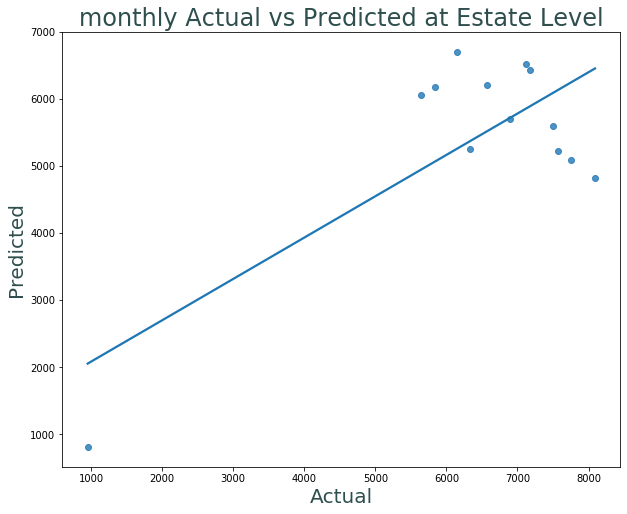

In [227]:
# Plot monthly estate level actaul vs predicted
xf=graph['crop']
yf=graph['crop_preds']
#cf=graph['']
xlabel='Actual'
ylabel='Predicted'
title = 'monthly Actual vs Predicted at Estate Level'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.regplot(xf,yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

In [187]:
dfi_m_train.columns

Index(['crop', 'area_ha', 'no_of_palms', 'syp1_prop', 'syp2_prop', 'syp3_prop', 'syp4_prop', 'syp5_prop', 'age', 'blk_eval',
       ...
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'rain_6', 'rain_12', 'rain_14', 'rain_26', 'date'], dtype='object', length=222)

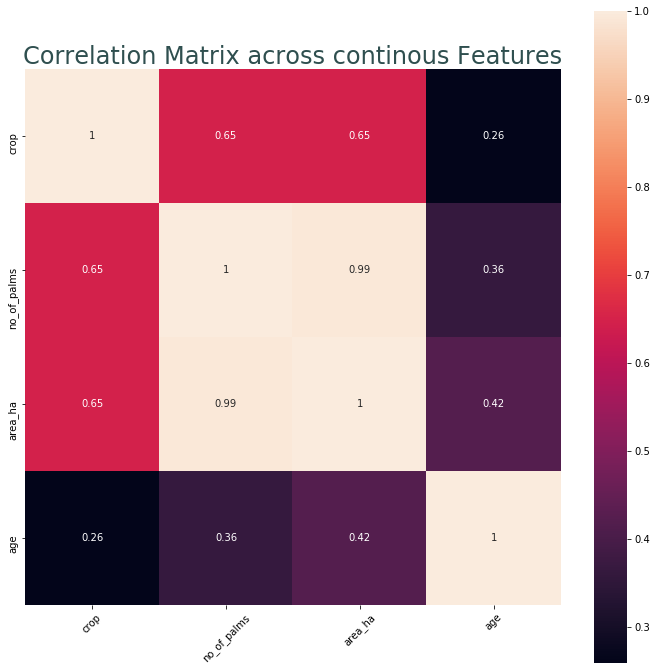

In [188]:
nums_df = dfi_m_train[['crop','no_of_palms','area_ha','age']]
# stores cross columns correlation matrix of continous features in final_corr dataframe
final_corr = nums_df.corr()
# create Seaborn heat map for cross columns correlation matrix stored within final_corr object.
fig, ax = plt.subplots(figsize=(12,12));
ax = sns.heatmap(final_corr, annot=True,square=True);
ax.set_title("Correlation Matrix across continous Features",color=my_title_col, fontsize = my_title_font);
plt.xticks(rotation=45);

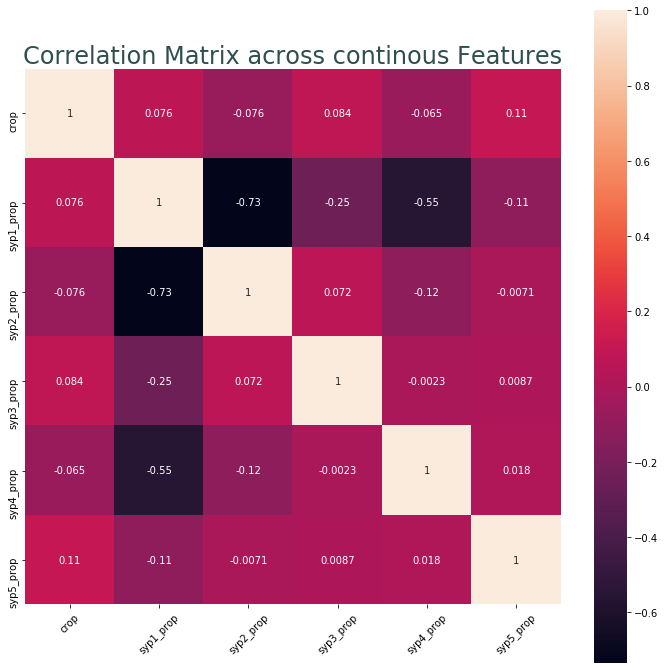

In [189]:
nums_df = dfi_m_train[['crop','syp1_prop', 'syp2_prop', 'syp3_prop', 'syp4_prop', 'syp5_prop']]
# stores cross columns correlation matrix of continous features in final_corr dataframe
final_corr = nums_df.corr()
# create Seaborn heat map for cross columns correlation matrix stored within final_corr object.
fig, ax = plt.subplots(figsize=(12,12));
ax = sns.heatmap(final_corr, annot=True,square=True);
ax.set_title("Correlation Matrix across continous Features",color=my_title_col, fontsize = my_title_font);
plt.xticks(rotation=45);

In [190]:
resd_perc = ((resd)/y_val)*100

In [191]:
display(y_val[0:10])
display(y_preds[0:10])

13403    41.30265
13404    17.60082
13405    35.29730
13406    48.95060
13407    27.50575
13408    16.21661
13409    39.24722
13410    38.38033
13411    46.75923
13412    33.51113
Name: crop, dtype: float64

array([42.77997629, 11.48017161, 29.41815989, 44.45038645, 13.83075754,
        8.15232384, 50.25605051,  4.05084761, 54.50556223, 36.25751536])

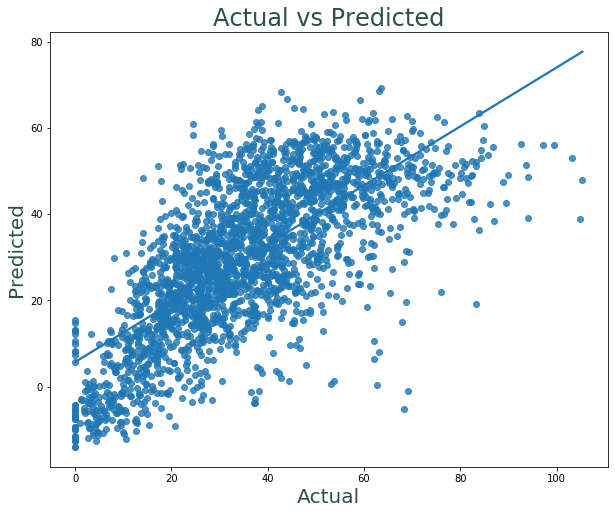

In [192]:
# Plot y_val and y_preds
xf=y_val
yf=y_preds
#cf=graph['']
xlabel='Actual'
ylabel='Predicted'
title = 'Actual vs Predicted'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.regplot(xf,yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

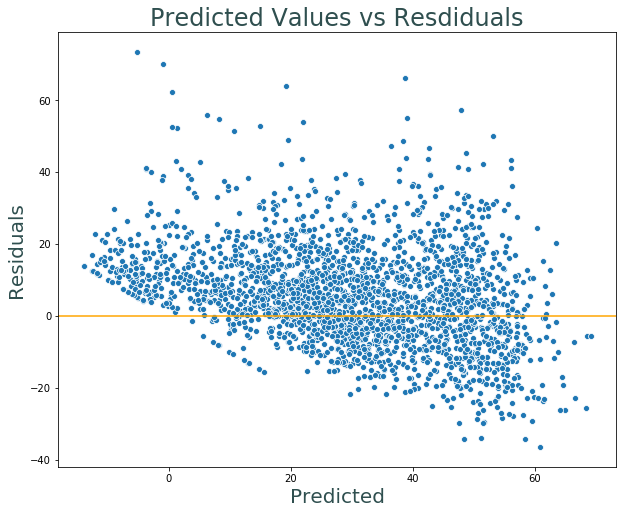

In [193]:
# Plot Predicted vs Residuals
xf=y_preds
yf=resd
#cf=graph['']
xlabel='Predicted'
ylabel='Residuals'
title = 'Predicted Values vs Resdiduals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(xf,yf,ci=None);
plt.axhline(0, color='orange');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

#### Scenerio- 9  Coef Analysis

In [194]:
#lr.coef_

In [195]:
print(len(X_train.columns),len(lr.coef_))

219 219


In [ ]:
features_coef = pd.DataFrame(lr.coef_, X_train.columns, columns=['Coeff'])

In [ ]:
features_coef.sort_values('Coeff',ascending=False).plot(kind='bar',figsize=(28,10));
plt.title('Features and Coefficients - Linear Regression',fontsize = 10);
plt.xticks(rotation=65);

In [ ]:
# top 50 features 
features_coef.sort_values('Coeff',ascending=False).head(50).plot(kind='bar',figsize=(16,10));
plt.title('Top 50 Features and Coefficients - Linear Regression',fontsize = 10);
plt.xticks(rotation=65);

In [ ]:
# bottom 50 features 
features_coef.sort_values('Coeff',ascending=False).tail(50).plot(kind='bar',figsize=(16,10));
plt.title('Top 50 Features and Coefficients - Linear Regression',fontsize = 8);
plt.xticks(rotation=65);

In [ ]:
features_coef.head()

#### Scenerio - 9 Lasso Regression 

In [ ]:
lassoCV = LassoCV(n_alphas=100,cv=5,verbose=0)
lassoCV.fit(X_train_scaled, y_train)
y_preds = lassoCV.predict(X_val_scaled)

scores_df = scores(scores_df,'Lasso lassoCV_S9','Train','R2',f'{round(lassoCV.score(X_train_scaled,y_train),4)}')
scores_df = scores(scores_df,'Lasso lassoCV_S9','Val','R2',f'{round(lassoCV.score(X_val_scaled,y_val),4)}')
scores_df = scores(scores_df,'Lasso lassoCV_S9','Val','Adj R2',f'{round((1-(1-r2_score(y_val, y_preds))*((len(X_val_scaled)-1)/(len(X_val_scaled)-len(X_val_scaled[0])-1))),4)}')
scores_df = scores(scores_df,'Lasso lassoCV_S9','train','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_train, lassoCV.predict(X_train_scaled))),2)}')
scores_df = scores(scores_df,'Lasso lassoCV_S9','Val','RMSE',f'{round(math.sqrt(metrics.mean_squared_error(y_val, lassoCV.predict(X_val_scaled))),2)}')
#scores_df = scores(scores_df,'Lasso lassoCV_S9','train','CVal_5',f'{round(cross_val_score(lassoCV, X_train_scaled, y_train, cv=5).mean(),4)}')
scores_df.tail(5)


In [ ]:
# residual of LR model on validation dataset
# residual of LR model on validation dataset
print(len(y_val),len(y_preds),len(df_val))
resd = y_val - y_preds
df_eval = df_val.copy()
df_eval['crop_preds'] = y_preds
df_eval['variance'] = (df_eval['crop'] - df_eval['crop_preds'])
df_eval[['date','blk_eval','crop','crop_preds','variance']].head()

In [ ]:
# Plot y_val and y_preds
xf=y_val
yf=y_preds
#cf=graph['']
xlabel='Actual'
ylabel='Predicted'
title = 'Actual vs Predicted'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.regplot(xf,yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

In [ ]:
# Plot Predicted vs Residuals
xf=y_preds
yf=resd
#cf=graph['']
xlabel='Predicted'
ylabel='Residuals'
title = 'Predicted Values vs Resdiduals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(xf,yf,ci=None);
plt.axhline(0, color='orange');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

In [ ]:
# Plot Actual vs Residuals
xf=y_val
yf=resd
#cf=graph['']
xlabel='Actual'
ylabel='Residuals'
title = 'Actual Values vs Residuals'
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(xf,yf,ci=None);
plt.axhline(0, color='orange');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

In [ ]:
# Extracting the features with lassoCV.Coef_ value as zero
features_coef = pd.DataFrame(lassoCV.coef_, X_train.columns, columns=['Coeff'])
zero_coef = pd.DataFrame(features_coef[abs(features_coef['Coeff']) == 0])
print(zero_coef)
print('No. of features with zero lassoCV Coef :',len(pd.DataFrame(features_coef[abs(features_coef['Coeff']) == 0])))

In [ ]:
zero_coef_list = zero_coef.index
zero_coef_list

In [ ]:
# list of features with coef not equal to zero. 
selected_feat_coef = pd.DataFrame(features_coef[abs(features_coef['Coeff']) != 0]).sort_values('Coeff')
selected_feat_coef.count()

In [ ]:
selected_feat_coef.plot(kind='bar',figsize=(30,10));
plt.title('Selected Features and Coefficients - LassoCV',fontsize = 15);
plt.xticks(rotation=65);

In [ ]:
# top 50 features 
features_coef.sort_values('Coeff',ascending=False).head(50).plot(kind='bar',figsize=(16,10));
plt.title('Top 50 Features and Coefficients - LassoCV',fontsize = 10);
plt.xticks(rotation=65);

In [ ]:
# bottom 50 features 
features_coef.sort_values('Coeff',ascending=False).tail(50).plot(kind='bar',figsize=(16,10));
plt.title('Bottom 50 Features and Coefficients - LassoCV',fontsize = 10);
plt.xticks(rotation=65);

In [ ]:
features_coef.tail(10)

In [ ]:
scores_df['Score'] = scores_df['Score'].astype(float)
scores_df[scores_df['Metric'] == 'RMSE'].sort_values(by='Score')